Import important parameter

In [1]:
inputsize =51
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/4)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/4)

h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R =  np.matmul(Restriction(int(inputsize/2)),Restriction(inputsize))
P = 4.*np.transpose(R)


In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, 2/3, 1e-12)

Residual = 0.8363429714759497
Interation = 1
Residual = 0.20930963787083984
Interation = 2
Residual = 0.10658940419721528
Interation = 3
Residual = 0.06243776347114833
Interation = 4
Residual = 0.03883268229549119
Interation = 5
Residual = 0.024791511970413006
Interation = 6
Residual = 0.01608404782725832
Interation = 7
Residual = 0.010567508870377749
Interation = 8
Residual = 0.007016898911900462
Interation = 9
Residual = 0.0047004654440957715
Interation = 10
Residual = 0.003171356745053204
Interation = 11
Residual = 0.0021518947961671796
Interation = 12
Residual = 0.0014666516611338894
Interation = 13
Residual = 0.001003043834118617
Interation = 14
Residual = 0.000687778065172124
Interation = 15
Residual = 0.00047254109522280494
Interation = 16
Residual = 0.00032515157267940713
Interation = 17
Residual = 0.00022399107801762176
Interation = 18
Residual = 0.0001544392134941706
Interation = 19
Residual = 0.00010655656507487528
Interation = 20
Residual = 7.355890071587057e-05
Interation 

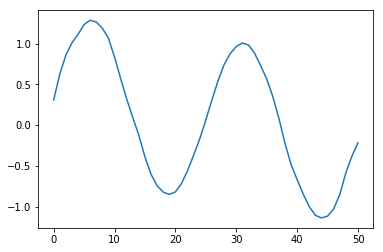

In [6]:
plt.plot(GMM_U)

In [7]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.7162902580611564


Local DMM on fine grid

In [8]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-5,accept_radius = 1 ,step_length = 1e-3, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.002
rho = 0.6524217561586165
L = 0.003
rho = 0.6524201490981191
L = 0.004
rho = 0.6524190795116425
L = 0.005
rho = 0.6524185438702859
L = 0.006
rho = 0.6524185386656522
L = 0.007
rho = 0.6524190604097105
L = 0.008
rho = 0.6524201056346511
L = 0.009000000000000001
rho = 0.6524216708927492
L = 0.010000000000000002
rho = 0.6524237527562258
L = 0.011000000000000003
rho = 0.6524263478171148
L = 0.012000000000000004
rho = 0.6524294526871284
L = 0.013000000000000005
rho = 0.6524330639975248
L = 0.014000000000000005
rho = 0.6524371783989815
L = 0.015000000000000006
rho = 0.6524417925614686
L = 0.016000000000000007
rho = 0.6524469031741164
L = 0.017000000000000008
rho = 0.6524525069451014
L = 0.01800000000000001
rho = 0.652458600601513
L = 0.01900000000000001
rho = 0.6524651808892422
L = 0.02000000000000001
rho = 0.6524722445728582
L = 0.02100000000000001
rho = 0.6524797884354884
L = 0.022000000000000013
rho = 0.6524878092787076
L = 0.023000000000000013
rho = 0.65249

L = 0.1390000000000001
rho = 0.6559758690858162
L = 0.1400000000000001
rho = 0.6560221242409895
L = 0.1410000000000001
rho = 0.6560685824301
L = 0.1420000000000001
rho = 0.6561152420798702
L = 0.1430000000000001
rho = 0.6561621016268054
L = 0.1440000000000001
rho = 0.6562091595171435
L = 0.1450000000000001
rho = 0.656256414206803
L = 0.1460000000000001
rho = 0.6563038641613321
L = 0.1470000000000001
rho = 0.6563515078558559
L = 0.1480000000000001
rho = 0.656399343775029
L = 0.1490000000000001
rho = 0.6564473704129791
L = 0.1500000000000001
rho = 0.6564955862732614
L = 0.1510000000000001
rho = 0.656543989868807
L = 0.1520000000000001
rho = 0.6565925797218682
L = 0.1530000000000001
rho = 0.6566413543639762
L = 0.1540000000000001
rho = 0.6566903123358809
L = 0.1550000000000001
rho = 0.6567394521875136
L = 0.1560000000000001
rho = 0.6567887724779249
L = 0.1570000000000001
rho = 0.656838271775243
L = 0.1580000000000001
rho = 0.6568879486566215
L = 0.1590000000000001
rho = 0.6569378017081935

L = 0.2740000000000002
rho = 0.6635387142293755
L = 0.2750000000000002
rho = 0.6636014475884912
L = 0.2760000000000002
rho = 0.6636642416458417
L = 0.2770000000000002
rho = 0.6637270957512603
L = 0.2780000000000002
rho = 0.6637900092589719
L = 0.2790000000000002
rho = 0.6638529815275649
L = 0.2800000000000002
rho = 0.6639160119199619
L = 0.2810000000000002
rho = 0.6639790998033911
L = 0.2820000000000002
rho = 0.6640422445493646
L = 0.2830000000000002
rho = 0.6641054455336416
L = 0.2840000000000002
rho = 0.6641687021362108
L = 0.2850000000000002
rho = 0.6642320137412554
L = 0.2860000000000002
rho = 0.6642953797371298
L = 0.2870000000000002
rho = 0.6643587995163337
L = 0.2880000000000002
rho = 0.6644222724754835
L = 0.2890000000000002
rho = 0.6644857980152858
L = 0.2900000000000002
rho = 0.6645493755405139
L = 0.2910000000000002
rho = 0.6646130044599762
L = 0.2920000000000002
rho = 0.6646766841864958
L = 0.2930000000000002
rho = 0.6647404141368805
L = 0.2940000000000002
rho = 0.664804193

L = 0.4180000000000003
rho = 0.6729439937446821
L = 0.4190000000000003
rho = 0.6730105014998123
L = 0.4200000000000003
rho = 0.6730770103166351
L = 0.4210000000000003
rho = 0.6731435199557957
L = 0.4220000000000003
rho = 0.6732100301796382
L = 0.4230000000000003
rho = 0.6732765407521931
L = 0.4240000000000003
rho = 0.6733430514391683
L = 0.4250000000000003
rho = 0.6734095620079329
L = 0.4260000000000003
rho = 0.6734760722275123
L = 0.4270000000000003
rho = 0.6735425818685752
L = 0.4280000000000003
rho = 0.6736090907034182
L = 0.4290000000000003
rho = 0.6736755985059633
L = 0.4300000000000003
rho = 0.6737421050517366
L = 0.4310000000000003
rho = 0.6738086101178692
L = 0.43200000000000033
rho = 0.6738751134830778
L = 0.43300000000000033
rho = 0.6739416149276577
L = 0.43400000000000033
rho = 0.6740081142334713
L = 0.43500000000000033
rho = 0.6740746111839382
L = 0.43600000000000033
rho = 0.6741411055640243
L = 0.43700000000000033
rho = 0.6742075971602335
L = 0.43800000000000033
rho = 0.67

L = 0.5590000000000004
rho = 0.682245167145861
L = 0.5600000000000004
rho = 0.6823100886867984
L = 0.5610000000000004
rho = 0.6823749901342351
L = 0.5620000000000004
rho = 0.6824398714045191
L = 0.5630000000000004
rho = 0.6825047324146613
L = 0.5640000000000004
rho = 0.6825695730823317
L = 0.5650000000000004
rho = 0.6826343933258576
L = 0.5660000000000004
rho = 0.6826991930642126
L = 0.5670000000000004
rho = 0.6827639722170196
L = 0.5680000000000004
rho = 0.6828287307045423
L = 0.5690000000000004
rho = 0.6828934684476825
L = 0.5700000000000004
rho = 0.6829581853679755
L = 0.5710000000000004
rho = 0.6830228813875844
L = 0.5720000000000004
rho = 0.6830875564293002
L = 0.5730000000000004
rho = 0.6831522104165322
L = 0.5740000000000004
rho = 0.6832168432733072
L = 0.5750000000000004
rho = 0.683281454924265
L = 0.5760000000000004
rho = 0.6833460452946548
L = 0.5770000000000004
rho = 0.6834106143103292
L = 0.5780000000000004
rho = 0.6834751618977423
L = 0.5790000000000004
rho = 0.68353968798

L = 0.6990000000000005
rho = 0.6911098115883952
L = 0.7000000000000005
rho = 0.6911713461649619
L = 0.7010000000000005
rho = 0.6912328537986938
L = 0.7020000000000005
rho = 0.6912943344664917
L = 0.7030000000000005
rho = 0.6913557881455129
L = 0.7040000000000005
rho = 0.6914172148131723
L = 0.7050000000000005
rho = 0.6914786144471434
L = 0.7060000000000005
rho = 0.6915399870253506
L = 0.7070000000000005
rho = 0.6916013325259694
L = 0.7080000000000005
rho = 0.6916626509274271
L = 0.7090000000000005
rho = 0.6917239422084
L = 0.7100000000000005
rho = 0.6917852063478107
L = 0.7110000000000005
rho = 0.6918464433248268
L = 0.7120000000000005
rho = 0.6919076531188589
L = 0.7130000000000005
rho = 0.6919688357095604
L = 0.7140000000000005
rho = 0.6920299910768232
L = 0.7150000000000005
rho = 0.6920911192007801
L = 0.7160000000000005
rho = 0.6921522200617969
L = 0.7170000000000005
rho = 0.692213293640479
L = 0.7180000000000005
rho = 0.6922743399176621
L = 0.7190000000000005
rho = 0.6923353588744

L = 0.8430000000000006
rho = 0.6996858372445928
L = 0.8440000000000006
rho = 0.6997433546925084
L = 0.8450000000000006
rho = 0.6998008438377397
L = 0.8460000000000006
rho = 0.6998583046806961
L = 0.8470000000000006
rho = 0.6999157372218806
L = 0.8480000000000006
rho = 0.6999731414618846
L = 0.8490000000000006
rho = 0.7000305174013933
L = 0.8500000000000006
rho = 0.7000878650411797
L = 0.8510000000000006
rho = 0.7001451843821068
L = 0.8520000000000006
rho = 0.7002024754251273
L = 0.8530000000000006
rho = 0.7002597381712793
L = 0.8540000000000006
rho = 0.7003169726216893
L = 0.8550000000000006
rho = 0.7003741787775725
L = 0.8560000000000006
rho = 0.7004313566402262
L = 0.8570000000000007
rho = 0.7004885062110353
L = 0.8580000000000007
rho = 0.7005456274914699
L = 0.8590000000000007
rho = 0.7006027204830826
L = 0.8600000000000007
rho = 0.7006597851875094
L = 0.8610000000000007
rho = 0.7007168216064693
L = 0.8620000000000007
rho = 0.7007738297417647
L = 0.8630000000000007
rho = 0.700830809

L = 0.9840000000000008
rho = 0.707517830496021
L = 0.9850000000000008
rho = 0.7075713942371991
L = 0.9860000000000008
rho = 0.7076249303882438
L = 0.9870000000000008
rho = 0.7076784389574745
L = 0.9880000000000008
rho = 0.7077319199532405
L = 0.9890000000000008
rho = 0.7077853733839216
L = 0.9900000000000008
rho = 0.7078387992579234
L = 0.9910000000000008
rho = 0.7078921975836858
L = 0.9920000000000008
rho = 0.7079455683696758
L = 0.9930000000000008
rho = 0.7079989116243905
L = 0.9940000000000008
rho = 0.7080522273563538
L = 0.9950000000000008
rho = 0.7081055155741212
L = 0.9960000000000008
rho = 0.7081587762862727
L = 0.9970000000000008
rho = 0.7082120095014216
L = 0.9980000000000008
rho = 0.7082652152282045
L = 0.9990000000000008
rho = 0.7083183934752879
L = 1.0000000000000007
rho = 0.7083715442513654
======Section 2======
the 0 steps
rho = 0.7084246675651581
the 1 steps
rho = 0.7084150648095908
the 2 steps
rho = 0.7084054680989844
the 3 steps
rho = 0.7083958773753785
the 4 steps
rho

the 162 steps
rho = 0.7069207411860191
the 163 steps
rho = 0.7069116668271253
the 164 steps
rho = 0.7069025941100183
the 165 steps
rho = 0.7068935230239957
the 166 steps
rho = 0.7068844535584536
the 167 steps
rho = 0.7068753857028884
the 168 steps
rho = 0.7068663194468955
the 169 steps
rho = 0.7068572547801683
the 170 steps
rho = 0.7068481916924978
the 171 steps
rho = 0.7068391301737705
the 172 steps
rho = 0.7068300702139686
the 173 steps
rho = 0.7068210118031658
the 174 steps
rho = 0.7068119549315317
the 175 steps
rho = 0.7068028995893272
the 176 steps
rho = 0.7067938457669034
the 177 steps
rho = 0.7067847934547036
the 178 steps
rho = 0.7067757426432574
the 179 steps
rho = 0.7067666933231856
the 180 steps
rho = 0.7067576454851962
the 181 steps
rho = 0.7067485991200819
the 182 steps
rho = 0.7067395542187241
the 183 steps
rho = 0.7067305107720864
the 184 steps
rho = 0.7067214687712183
the 185 steps
rho = 0.706712428207249
the 186 steps
rho = 0.7067033890713961
the 187 steps
rho = 0.7066

the 347 steps
rho = 0.7052622579765148
the 348 steps
rho = 0.7052533752510682
the 349 steps
rho = 0.7052444931998042
the 350 steps
rho = 0.7052356118205281
the 351 steps
rho = 0.7052267311110647
the 352 steps
rho = 0.705217851069256
the 353 steps
rho = 0.7052089716929552
the 354 steps
rho = 0.7052000929800337
the 355 steps
rho = 0.7051912149283798
the 356 steps
rho = 0.7051823375358917
the 357 steps
rho = 0.7051734608004894
the 358 steps
rho = 0.7051645847201028
the 359 steps
rho = 0.7051557092926822
the 360 steps
rho = 0.7051468345161854
the 361 steps
rho = 0.705137960388591
the 362 steps
rho = 0.7051290869078878
the 363 steps
rho = 0.7051202140720809
the 364 steps
rho = 0.7051113418791907
the 365 steps
rho = 0.7051024703272496
the 366 steps
rho = 0.7050935994143035
the 367 steps
rho = 0.7050847291384142
the 368 steps
rho = 0.7050758594976559
the 369 steps
rho = 0.7050669904901167
the 370 steps
rho = 0.7050581221138982
the 371 steps
rho = 0.7050492543671145
the 372 steps
rho = 0.70504

the 517 steps
rho = 0.7037605216733344
the 518 steps
rho = 0.7037517311588588
the 519 steps
rho = 0.7037429410912888
the 520 steps
rho = 0.7037341514698107
the 521 steps
rho = 0.7037253622936128
the 522 steps
rho = 0.703716573561889
the 523 steps
rho = 0.7037077852738346
the 524 steps
rho = 0.7036989974286479
the 525 steps
rho = 0.7036902100255337
the 526 steps
rho = 0.7036814230636955
the 527 steps
rho = 0.7036726365423462
the 528 steps
rho = 0.703663850460696
the 529 steps
rho = 0.7036550648179624
the 530 steps
rho = 0.7036462796133639
the 531 steps
rho = 0.7036374948461237
the 532 steps
rho = 0.7036287105154662
the 533 steps
rho = 0.7036199266206216
the 534 steps
rho = 0.7036111431608222
the 535 steps
rho = 0.7036023601353012
the 536 steps
rho = 0.7035935775432995
the 537 steps
rho = 0.7035847953840567
the 538 steps
rho = 0.7035760136568193
the 539 steps
rho = 0.7035672323608323
the 540 steps
rho = 0.7035584514953478
the 541 steps
rho = 0.7035496710596176
the 542 steps
rho = 0.70354

the 693 steps
rho = 0.7022196522386004
the 694 steps
rho = 0.7022109301603405
the 695 steps
rho = 0.7022022084222502
the 696 steps
rho = 0.7021934870238641
the 697 steps
rho = 0.7021847659647181
the 698 steps
rho = 0.7021760452443525
the 699 steps
rho = 0.7021673248623065
the 700 steps
rho = 0.7021586048181196
the 701 steps
rho = 0.7021498851113347
the 702 steps
rho = 0.7021411657414924
the 703 steps
rho = 0.7021324467081385
the 704 steps
rho = 0.7021237280108162
the 705 steps
rho = 0.7021150096490728
the 706 steps
rho = 0.7021062916224527
the 707 steps
rho = 0.7020975739305065
the 708 steps
rho = 0.7020888565727814
the 709 steps
rho = 0.7020801395488278
the 710 steps
rho = 0.702071422858198
the 711 steps
rho = 0.7020627065004421
the 712 steps
rho = 0.7020539904751141
the 713 steps
rho = 0.7020452747817678
the 714 steps
rho = 0.7020365594199589
the 715 steps
rho = 0.7020278443892426
the 716 steps
rho = 0.7020191296891763
the 717 steps
rho = 0.7020104153193182
the 718 steps
rho = 0.7020

the 861 steps
rho = 0.7007587853688061
the 862 steps
rho = 0.7007501146460693
the 863 steps
rho = 0.7007414441978098
the 864 steps
rho = 0.7007327740236964
the 865 steps
rho = 0.7007241041233969
the 866 steps
rho = 0.7007154344965814
the 867 steps
rho = 0.7007067651429194
the 868 steps
rho = 0.7006980960620816
the 869 steps
rho = 0.7006894272537395
the 870 steps
rho = 0.7006807587175639
the 871 steps
rho = 0.7006720904532282
the 872 steps
rho = 0.7006634224604061
the 873 steps
rho = 0.7006547547387681
the 874 steps
rho = 0.7006460872879894
the 875 steps
rho = 0.7006374201077462
the 876 steps
rho = 0.7006287531977121
the 877 steps
rho = 0.7006200865575614
the 878 steps
rho = 0.7006114201869725
the 879 steps
rho = 0.7006027540856222
the 880 steps
rho = 0.7005940882531856
the 881 steps
rho = 0.7005854226893421
the 882 steps
rho = 0.7005767573937698
the 883 steps
rho = 0.700568092366147
the 884 steps
rho = 0.7005594276061539
the 885 steps
rho = 0.7005507631134708
the 886 steps
rho = 0.7005

the 1035 steps
rho = 0.6992539438031004
the 1036 steps
rho = 0.6992453162878716
the 1037 steps
rho = 0.699236688996823
the 1038 steps
rho = 0.6992280619297042
the 1039 steps
rho = 0.6992194350862622
the 1040 steps
rho = 0.6992108084662466
the 1041 steps
rho = 0.6992021820694069
the 1042 steps
rho = 0.6991935558954938
the 1043 steps
rho = 0.6991849299442551
the 1044 steps
rho = 0.6991763042154439
the 1045 steps
rho = 0.6991676787088091
the 1046 steps
rho = 0.6991590534241027
the 1047 steps
rho = 0.6991504283610753
the 1048 steps
rho = 0.6991418035194804
the 1049 steps
rho = 0.6991331788990696
the 1050 steps
rho = 0.6991245544995939
the 1051 steps
rho = 0.6991159303208093
the 1052 steps
rho = 0.699107306362467
the 1053 steps
rho = 0.6990986826243217
the 1054 steps
rho = 0.6990900591061269
the 1055 steps
rho = 0.6990814358076374
the 1056 steps
rho = 0.699072812728608
the 1057 steps
rho = 0.6990641898687937
the 1058 steps
rho = 0.6990555672279494
the 1059 steps
rho = 0.6990469448058322
the

the 1176 steps
rho = 0.6980395672108082
the 1177 steps
rho = 0.698030968978008
the 1178 steps
rho = 0.6980223709372165
the 1179 steps
rho = 0.6980137730882274
the 1180 steps
rho = 0.6980051754308348
the 1181 steps
rho = 0.6979965779648333
the 1182 steps
rho = 0.697987980690016
the 1183 steps
rho = 0.6979793836061784
the 1184 steps
rho = 0.6979707867131159
the 1185 steps
rho = 0.6979621900106243
the 1186 steps
rho = 0.6979535934984964
the 1187 steps
rho = 0.6979449971765307
the 1188 steps
rho = 0.6979364010445221
the 1189 steps
rho = 0.6979278051022662
the 1190 steps
rho = 0.697919209349562
the 1191 steps
rho = 0.6979106137862052
the 1192 steps
rho = 0.6979020184119922
the 1193 steps
rho = 0.6978934232267205
the 1194 steps
rho = 0.6978848282301883
the 1195 steps
rho = 0.697876233422194
the 1196 steps
rho = 0.6978676388025357
the 1197 steps
rho = 0.6978590443710113
the 1198 steps
rho = 0.6978504501274198
the 1199 steps
rho = 0.6978418560715597
the 1200 steps
rho = 0.6978332622032322
the 

the 1348 steps
rho = 0.6965633320621588
the 1349 steps
rho = 0.6965547640343556
the 1350 steps
rho = 0.696546196166758
the 1351 steps
rho = 0.6965376284592006
the 1352 steps
rho = 0.6965290609115173
the 1353 steps
rho = 0.6965204935235445
the 1354 steps
rho = 0.6965119262951182
the 1355 steps
rho = 0.6965033592260713
the 1356 steps
rho = 0.6964947923162427
the 1357 steps
rho = 0.696486225565466
the 1358 steps
rho = 0.6964776589735778
the 1359 steps
rho = 0.696469092540416
the 1360 steps
rho = 0.6964605262658151
the 1361 steps
rho = 0.696451960149613
the 1362 steps
rho = 0.6964433941916469
the 1363 steps
rho = 0.6964348283917536
the 1364 steps
rho = 0.6964262627497703
the 1365 steps
rho = 0.6964176972655343
the 1366 steps
rho = 0.6964091319388848
the 1367 steps
rho = 0.6964005667696583
the 1368 steps
rho = 0.6963920017576936
the 1369 steps
rho = 0.6963834369028296
the 1370 steps
rho = 0.696374872204903
the 1371 steps
rho = 0.6963663076637545
the 1372 steps
rho = 0.6963577432792227
the 1

the 1514 steps
rho = 0.6951431156704204
the 1515 steps
rho = 0.6951345721172215
the 1516 steps
rho = 0.6951260286993677
the 1517 steps
rho = 0.695117485416724
the 1518 steps
rho = 0.6951089422691568
the 1519 steps
rho = 0.6951003992565271
the 1520 steps
rho = 0.6950918563787039
the 1521 steps
rho = 0.6950833136355493
the 1522 steps
rho = 0.6950747710269318
the 1523 steps
rho = 0.6950662285527154
the 1524 steps
rho = 0.6950576862127649
the 1525 steps
rho = 0.6950491440069478
the 1526 steps
rho = 0.6950406019351294
the 1527 steps
rho = 0.6950320599971769
the 1528 steps
rho = 0.6950235181929547
the 1529 steps
rho = 0.6950149765223301
the 1530 steps
rho = 0.6950064349851702
the 1531 steps
rho = 0.6949978935813422
the 1532 steps
rho = 0.694989352310712
the 1533 steps
rho = 0.6949808111731461
the 1534 steps
rho = 0.6949722701685147
the 1535 steps
rho = 0.6949637292966826
the 1536 steps
rho = 0.6949551885575178
the 1537 steps
rho = 0.6949466479508883
the 1538 steps
rho = 0.694938107476662
the

the 1690 steps
rho = 0.6936414195084176
the 1691 steps
rho = 0.6936328978236934
the 1692 steps
rho = 0.6936243762527283
the 1693 steps
rho = 0.693615854795409
the 1694 steps
rho = 0.6936073334516266
the 1695 steps
rho = 0.6935988122212696
the 1696 steps
rho = 0.6935902911042291
the 1697 steps
rho = 0.6935817701003935
the 1698 steps
rho = 0.6935732492096528
the 1699 steps
rho = 0.6935647284318969
the 1700 steps
rho = 0.6935562077670168
the 1701 steps
rho = 0.6935476872149001
the 1702 steps
rho = 0.6935391667754414
the 1703 steps
rho = 0.6935306464485275
the 1704 steps
rho = 0.693522126234051
the 1705 steps
rho = 0.6935136061319006
the 1706 steps
rho = 0.6935050861419685
the 1707 steps
rho = 0.6934965662641462
the 1708 steps
rho = 0.6934880464983232
the 1709 steps
rho = 0.6934795268443914
the 1710 steps
rho = 0.6934710073022425
the 1711 steps
rho = 0.6934624878717676
the 1712 steps
rho = 0.693453968552857
the 1713 steps
rho = 0.6934454493454052
the 1714 steps
rho = 0.6934369302493029
the

the 1865 steps
rho = 0.6921517638537649
the 1866 steps
rho = 0.6921432604929574
the 1867 steps
rho = 0.6921347572282769
the 1868 steps
rho = 0.6921262540596294
the 1869 steps
rho = 0.6921177509869262
the 1870 steps
rho = 0.692109248010076
the 1871 steps
rho = 0.6921007451289862
the 1872 steps
rho = 0.6920922423435689
the 1873 steps
rho = 0.6920837396537295
the 1874 steps
rho = 0.69207523705938
the 1875 steps
rho = 0.6920667345604284
the 1876 steps
rho = 0.6920582321567871
the 1877 steps
rho = 0.69204972984836
the 1878 steps
rho = 0.6920412276350625
the 1879 steps
rho = 0.6920327255168015
the 1880 steps
rho = 0.6920242234934891
the 1881 steps
rho = 0.6920157215650317
the 1882 steps
rho = 0.692007219731343
the 1883 steps
rho = 0.6919987179923313
the 1884 steps
rho = 0.6919902163479069
the 1885 steps
rho = 0.6919817147979815
the 1886 steps
rho = 0.6919732133424645
the 1887 steps
rho = 0.6919647119812665
the 1888 steps
rho = 0.6919562107142986
the 1889 steps
rho = 0.6919477095414724
the 18

the 2036 steps
rho = 0.6906990149379891
the 2037 steps
rho = 0.690690526766611
the 2038 steps
rho = 0.6906820386771257
the 2039 steps
rho = 0.6906735506694581
the 2040 steps
rho = 0.6906650627435328
the 2041 steps
rho = 0.6906565748992738
the 2042 steps
rho = 0.6906480871366069
the 2043 steps
rho = 0.6906395994554558
the 2044 steps
rho = 0.6906311118557454
the 2045 steps
rho = 0.6906226243374011
the 2046 steps
rho = 0.6906141369003483
the 2047 steps
rho = 0.6906056495445123
the 2048 steps
rho = 0.6905971622698173
the 2049 steps
rho = 0.6905886750761878
the 2050 steps
rho = 0.6905801879635519
the 2051 steps
rho = 0.6905717009318324
the 2052 steps
rho = 0.6905632139809573
the 2053 steps
rho = 0.6905547271108502
the 2054 steps
rho = 0.6905462403214375
the 2055 steps
rho = 0.6905377536126452
the 2056 steps
rho = 0.6905292669843985
the 2057 steps
rho = 0.6905207804366255
the 2058 steps
rho = 0.6905122939692487
the 2059 steps
rho = 0.6905038075821973
the 2060 steps
rho = 0.6904953212753955
t

the 2208 steps
rho = 0.6892401937026709
the 2209 steps
rho = 0.6892317185735138
the 2210 steps
rho = 0.6892232435144335
the 2211 steps
rho = 0.6892147685253678
the 2212 steps
rho = 0.6892062936062556
the 2213 steps
rho = 0.6891978187570337
the 2214 steps
rho = 0.6891893439776399
the 2215 steps
rho = 0.6891808692680147
the 2216 steps
rho = 0.6891723946280941
the 2217 steps
rho = 0.6891639200578176
the 2218 steps
rho = 0.6891554455571228
the 2219 steps
rho = 0.6891469711259488
the 2220 steps
rho = 0.6891384967642339
the 2221 steps
rho = 0.689130022471917
the 2222 steps
rho = 0.689121548248936
the 2223 steps
rho = 0.6891130740952301
the 2224 steps
rho = 0.6891046000107379
the 2225 steps
rho = 0.6890961259953992
the 2226 steps
rho = 0.6890876520491521
the 2227 steps
rho = 0.689079178171936
the 2228 steps
rho = 0.6890707043636897
the 2229 steps
rho = 0.6890622306243538
the 2230 steps
rho = 0.6890537569538645
the 2231 steps
rho = 0.6890452833521638
the 2232 steps
rho = 0.6890368098191897
the

the 2363 steps
rho = 0.6879273488795401
the 2364 steps
rho = 0.6879188839137488
the 2365 steps
rho = 0.6879104190092357
the 2366 steps
rho = 0.6879019541659511
the 2367 steps
rho = 0.6878934893838433
the 2368 steps
rho = 0.6878850246628586
the 2369 steps
rho = 0.6878765600029481
the 2370 steps
rho = 0.6878680954040596
the 2371 steps
rho = 0.6878596308661414
the 2372 steps
rho = 0.6878511663891436
the 2373 steps
rho = 0.6878427019730142
the 2374 steps
rho = 0.6878342376177015
the 2375 steps
rho = 0.6878257733231562
the 2376 steps
rho = 0.6878173090893261
the 2377 steps
rho = 0.6878088449161608
the 2378 steps
rho = 0.6878003808036088
the 2379 steps
rho = 0.6877919167516211
the 2380 steps
rho = 0.6877834527601449
the 2381 steps
rho = 0.6877749888291316
the 2382 steps
rho = 0.6877665249585292
the 2383 steps
rho = 0.6877580611482879
the 2384 steps
rho = 0.6877495973983565
the 2385 steps
rho = 0.6877411337086861
the 2386 steps
rho = 0.6877326700792252
the 2387 steps
rho = 0.6877242065099242


the 2544 steps
rho = 0.6863961408991862
the 2545 steps
rho = 0.6863876862453765
the 2546 steps
rho = 0.6863792316445144
the 2547 steps
rho = 0.6863707770965586
the 2548 steps
rho = 0.6863623226014689
the 2549 steps
rho = 0.6863538681592043
the 2550 steps
rho = 0.6863454137697249
the 2551 steps
rho = 0.6863369594329893
the 2552 steps
rho = 0.6863285051489579
the 2553 steps
rho = 0.68632005091759
the 2554 steps
rho = 0.6863115967388457
the 2555 steps
rho = 0.6863031426126842
the 2556 steps
rho = 0.6862946885390657
the 2557 steps
rho = 0.6862862345179498
the 2558 steps
rho = 0.6862777805492966
the 2559 steps
rho = 0.6862693266330655
the 2560 steps
rho = 0.6862608727692174
the 2561 steps
rho = 0.6862524189577122
the 2562 steps
rho = 0.6862439651985106
the 2563 steps
rho = 0.6862355114915709
the 2564 steps
rho = 0.6862270578368561
the 2565 steps
rho = 0.6862186042343236
the 2566 steps
rho = 0.6862101506839365
the 2567 steps
rho = 0.6862016971856533
the 2568 steps
rho = 0.6861932437394349
th

the 2686 steps
rho = 0.6851960920013896
the 2687 steps
rho = 0.6851876444844488
the 2688 steps
rho = 0.6851791970152242
the 2689 steps
rho = 0.685170749593681
the 2690 steps
rho = 0.6851623022197888
the 2691 steps
rho = 0.6851538548935128
the 2692 steps
rho = 0.6851454076148197
the 2693 steps
rho = 0.6851369603836774
the 2694 steps
rho = 0.6851285132000545
the 2695 steps
rho = 0.6851200660639157
the 2696 steps
rho = 0.6851116189752297
the 2697 steps
rho = 0.6851031719339638
the 2698 steps
rho = 0.6850947249400848
the 2699 steps
rho = 0.6850862779935603
the 2700 steps
rho = 0.6850778310943578
the 2701 steps
rho = 0.6850693842424458
the 2702 steps
rho = 0.6850609374377906
the 2703 steps
rho = 0.6850524906803606
the 2704 steps
rho = 0.6850440439701226
the 2705 steps
rho = 0.6850355973070472
the 2706 steps
rho = 0.6850271506910973
the 2707 steps
rho = 0.6850187041222452
the 2708 steps
rho = 0.6850102576004566
the 2709 steps
rho = 0.6850018111256997
the 2710 steps
rho = 0.6849933646979425
t

the 2866 steps
rho = 0.6836762781590858
the 2867 steps
rho = 0.6836678387457799
the 2868 steps
rho = 0.6836593993750304
the 2869 steps
rho = 0.6836509600468139
the 2870 steps
rho = 0.6836425207611054
the 2871 steps
rho = 0.6836340815178802
the 2872 steps
rho = 0.683625642317115
the 2873 steps
rho = 0.6836172031587856
the 2874 steps
rho = 0.6836087640428675
the 2875 steps
rho = 0.683600324969337
the 2876 steps
rho = 0.6835918859381686
the 2877 steps
rho = 0.6835834469493395
the 2878 steps
rho = 0.6835750080028266
the 2879 steps
rho = 0.6835665690986046
the 2880 steps
rho = 0.6835581302366492
the 2881 steps
rho = 0.6835496914169381
the 2882 steps
rho = 0.6835412526394467
the 2883 steps
rho = 0.6835328139041512
the 2884 steps
rho = 0.683524375211028
the 2885 steps
rho = 0.6835159365600532
the 2886 steps
rho = 0.6835074979512037
the 2887 steps
rho = 0.6834990593844557
the 2888 steps
rho = 0.6834906208597863
the 2889 steps
rho = 0.6834821823771708
the 2890 steps
rho = 0.6834737439365871
the

the 3008 steps
rho = 0.6824782968463258
the 3009 steps
rho = 0.6824698632529103
the 3010 steps
rho = 0.6824614296990327
the 3011 steps
rho = 0.6824529961846769
the 3012 steps
rho = 0.6824445627098217
the 3013 steps
rho = 0.6824361292744514
the 3014 steps
rho = 0.6824276958785463
the 3015 steps
rho = 0.6824192625220907
the 3016 steps
rho = 0.6824108292050637
the 3017 steps
rho = 0.6824023959274506
the 3018 steps
rho = 0.6823939626892307
the 3019 steps
rho = 0.6823855294903876
the 3020 steps
rho = 0.6823770963309025
the 3021 steps
rho = 0.6823686632107593
the 3022 steps
rho = 0.6823602301299386
the 3023 steps
rho = 0.6823517970884229
the 3024 steps
rho = 0.6823433640861956
the 3025 steps
rho = 0.682334931123238
the 3026 steps
rho = 0.6823264981995341
the 3027 steps
rho = 0.6823180653150641
the 3028 steps
rho = 0.6823096324698119
the 3029 steps
rho = 0.6823011996637598
the 3030 steps
rho = 0.6822927668968906
the 3031 steps
rho = 0.6822843341691867
the 3032 steps
rho = 0.6822759014806317
t

the 3150 steps
rho = 0.6812811145706098
the 3151 steps
rho = 0.6812726864286546
the 3152 steps
rho = 0.6812642583240602
the 3153 steps
rho = 0.681255830256815
the 3154 steps
rho = 0.6812474022269053
the 3155 steps
rho = 0.6812389742343191
the 3156 steps
rho = 0.6812305462790451
the 3157 steps
rho = 0.6812221183610696
the 3158 steps
rho = 0.6812136904803806
the 3159 steps
rho = 0.6812052626369659
the 3160 steps
rho = 0.6811968348308137
the 3161 steps
rho = 0.6811884070619104
the 3162 steps
rho = 0.6811799793302458
the 3163 steps
rho = 0.6811715516358062
the 3164 steps
rho = 0.6811631239785798
the 3165 steps
rho = 0.6811546963585553
the 3166 steps
rho = 0.6811462687757195
the 3167 steps
rho = 0.6811378412300609
the 3168 steps
rho = 0.6811294137215678
the 3169 steps
rho = 0.6811209862502288
the 3170 steps
rho = 0.6811125588160298
the 3171 steps
rho = 0.6811041314189615
the 3172 steps
rho = 0.6810957040590113
the 3173 steps
rho = 0.681087276736167
the 3174 steps
rho = 0.6810788494504171
th

the 3327 steps
rho = 0.6797899054760688
the 3328 steps
rho = 0.6797814837856572
the 3329 steps
rho = 0.6797730621309618
the 3330 steps
rho = 0.6797646405119782
the 3331 steps
rho = 0.6797562189286984
the 3332 steps
rho = 0.6797477973811183
the 3333 steps
rho = 0.6797393758692298
the 3334 steps
rho = 0.679730954393028
the 3335 steps
rho = 0.6797225329525076
the 3336 steps
rho = 0.6797141115476604
the 3337 steps
rho = 0.6797056901784833
the 3338 steps
rho = 0.6796972688449678
the 3339 steps
rho = 0.6796888475471099
the 3340 steps
rho = 0.6796804262849034
the 3341 steps
rho = 0.6796720050583415
the 3342 steps
rho = 0.679663583867421
the 3343 steps
rho = 0.6796551627121327
the 3344 steps
rho = 0.679646741592474
the 3345 steps
rho = 0.6796383205084384
the 3346 steps
rho = 0.6796298994600187
the 3347 steps
rho = 0.6796214784472118
the 3348 steps
rho = 0.6796130574700103
the 3349 steps
rho = 0.6796046365284099
the 3350 steps
rho = 0.679596215622404
the 3351 steps
rho = 0.6795877947519889
the 

the 3473 steps
rho = 0.6785607142311428
the 3474 steps
rho = 0.678552297707421
the 3475 steps
rho = 0.6785438812188705
the 3476 steps
rho = 0.6785354647654919
the 3477 steps
rho = 0.6785270483472813
the 3478 steps
rho = 0.6785186319642396
the 3479 steps
rho = 0.6785102156163642
the 3480 steps
rho = 0.6785017993036543
the 3481 steps
rho = 0.678493383026109
the 3482 steps
rho = 0.6784849667837268
the 3483 steps
rho = 0.6784765505765064
the 3484 steps
rho = 0.6784681344044468
the 3485 steps
rho = 0.6784597182675459
the 3486 steps
rho = 0.6784513021658057
the 3487 steps
rho = 0.6784428860992214
the 3488 steps
rho = 0.6784344700677944
the 3489 steps
rho = 0.6784260540715226
the 3490 steps
rho = 0.6784176381104062
the 3491 steps
rho = 0.6784092221844441
the 3492 steps
rho = 0.6784008062936341
the 3493 steps
rho = 0.6783923904379764
the 3494 steps
rho = 0.6783839746174707
the 3495 steps
rho = 0.6783755588321154
the 3496 steps
rho = 0.6783671430819089
the 3497 steps
rho = 0.6783587273668527
th

the 3645 steps
rho = 0.6771135893265208
the 3646 steps
rho = 0.6771051788575984
the 3647 steps
rho = 0.6770967684240552
the 3648 steps
rho = 0.6770883580258961
the 3649 steps
rho = 0.6770799476631243
the 3650 steps
rho = 0.6770715373357431
the 3651 steps
rho = 0.6770631270437572
the 3652 steps
rho = 0.6770547167871699
the 3653 steps
rho = 0.6770463065659856
the 3654 steps
rho = 0.6770378963802072
the 3655 steps
rho = 0.6770294862298384
the 3656 steps
rho = 0.6770210761148848
the 3657 steps
rho = 0.6770126660353496
the 3658 steps
rho = 0.6770042559912367
the 3659 steps
rho = 0.6769958459825498
the 3660 steps
rho = 0.6769874360092927
the 3661 steps
rho = 0.6769790260714715
the 3662 steps
rho = 0.6769706161690878
the 3663 steps
rho = 0.6769622063021469
the 3664 steps
rho = 0.6769537964706537
the 3665 steps
rho = 0.6769453866746109
the 3666 steps
rho = 0.6769369769140235
the 3667 steps
rho = 0.6769285671888958
the 3668 steps
rho = 0.6769201574992318
the 3669 steps
rho = 0.6769117478450365


the 3825 steps
rho = 0.6756002796087957
the 3826 steps
rho = 0.6755918755943099
the 3827 steps
rho = 0.6755834716163098
the 3828 steps
rho = 0.6755750676748044
the 3829 steps
rho = 0.6755666637698013
the 3830 steps
rho = 0.6755582599013101
the 3831 steps
rho = 0.6755498560693385
the 3832 steps
rho = 0.6755414522738952
the 3833 steps
rho = 0.6755330485149901
the 3834 steps
rho = 0.6755246447926295
the 3835 steps
rho = 0.6755162411068238
the 3836 steps
rho = 0.6755078374575814
the 3837 steps
rho = 0.6754994338449107
the 3838 steps
rho = 0.6754910302688204
the 3839 steps
rho = 0.6754826267293197
the 3840 steps
rho = 0.6754742232264177
the 3841 steps
rho = 0.6754658197601223
the 3842 steps
rho = 0.6754574163304428
the 3843 steps
rho = 0.6754490129373886
the 3844 steps
rho = 0.6754406095809676
the 3845 steps
rho = 0.6754322062611894
the 3846 steps
rho = 0.6754238029780634
the 3847 steps
rho = 0.6754153997315975
the 3848 steps
rho = 0.6754069965218
the 3849 steps
rho = 0.6753985933486818
the

the 3997 steps
rho = 0.6741553336293894
the 3998 steps
rho = 0.6741469360359061
the 3999 steps
rho = 0.6741385384807289
the 4000 steps
rho = 0.6741301409638693
the 4001 steps
rho = 0.6741217434853402
the 4002 steps
rho = 0.6741133460451533
the 4003 steps
rho = 0.6741049486433236
the 4004 steps
rho = 0.6740965512798619
the 4005 steps
rho = 0.6740881539547817
the 4006 steps
rho = 0.6740797566680953
the 4007 steps
rho = 0.6740713594198159
the 4008 steps
rho = 0.6740629622099558
the 4009 steps
rho = 0.6740545650385286
the 4010 steps
rho = 0.6740461679055464
the 4011 steps
rho = 0.6740377708110216
the 4012 steps
rho = 0.6740293737549685
the 4013 steps
rho = 0.674020976737399
the 4014 steps
rho = 0.6740125797583258
the 4015 steps
rho = 0.674004182817763
the 4016 steps
rho = 0.6739957859157221
the 4017 steps
rho = 0.6739873890522177
the 4018 steps
rho = 0.6739789922272615
the 4019 steps
rho = 0.6739705954408676
the 4020 steps
rho = 0.6739621986930476
the 4021 steps
rho = 0.6739538019838158
th

the 4183 steps
rho = 0.6725940546564064
the 4184 steps
rho = 0.6725856644278494
the 4185 steps
rho = 0.6725772742403172
the 4186 steps
rho = 0.672568884093828
the 4187 steps
rho = 0.6725604939883972
the 4188 steps
rho = 0.6725521039240417
the 4189 steps
rho = 0.6725437139007784
the 4190 steps
rho = 0.6725353239186243
the 4191 steps
rho = 0.6725269339775963
the 4192 steps
rho = 0.6725185440777092
the 4193 steps
rho = 0.6725101542189816
the 4194 steps
rho = 0.6725017644014305
the 4195 steps
rho = 0.6724933746250702
the 4196 steps
rho = 0.6724849848899205
the 4197 steps
rho = 0.6724765951959962
the 4198 steps
rho = 0.6724682055433154
the 4199 steps
rho = 0.672459815931894
the 4200 steps
rho = 0.6724514263617495
the 4201 steps
rho = 0.6724430368328986
the 4202 steps
rho = 0.6724346473453581
the 4203 steps
rho = 0.6724262578991451
the 4204 steps
rho = 0.672417868494276
the 4205 steps
rho = 0.6724094791307689
the 4206 steps
rho = 0.6724010898086402
the 4207 steps
rho = 0.6723927005279069
the

the 4335 steps
rho = 0.6713192206730187
the 4336 steps
rho = 0.6713108368821654
the 4337 steps
rho = 0.6713024531350859
the 4338 steps
rho = 0.6712940694317994
the 4339 steps
rho = 0.6712856857723265
the 4340 steps
rho = 0.6712773021566854
the 4341 steps
rho = 0.6712689185848969
the 4342 steps
rho = 0.6712605350569801
the 4343 steps
rho = 0.6712521515729546
the 4344 steps
rho = 0.6712437681328401
the 4345 steps
rho = 0.6712353847366566
the 4346 steps
rho = 0.6712270013844226
the 4347 steps
rho = 0.6712186180761593
the 4348 steps
rho = 0.6712102348118852
the 4349 steps
rho = 0.6712018515916216
the 4350 steps
rho = 0.6711934684153864
the 4351 steps
rho = 0.6711850852832006
the 4352 steps
rho = 0.6711767021950842
the 4353 steps
rho = 0.6711683191510562
the 4354 steps
rho = 0.6711599361511367
the 4355 steps
rho = 0.671151553195346
the 4356 steps
rho = 0.6711431702837024
the 4357 steps
rho = 0.6711347874162281
the 4358 steps
rho = 0.6711264045929418
the 4359 steps
rho = 0.671118021813864
th

the 4491 steps
rho = 0.6700118910878541
the 4492 steps
rho = 0.6700035143732801
the 4493 steps
rho = 0.6699951377057467
the 4494 steps
rho = 0.6699867610852763
the 4495 steps
rho = 0.669978384511892
the 4496 steps
rho = 0.6699700079856138
the 4497 steps
rho = 0.6699616315064679
the 4498 steps
rho = 0.669953255074473
the 4499 steps
rho = 0.6699448786896541
the 4500 steps
rho = 0.669936502352032
the 4501 steps
rho = 0.6699281260616293
the 4502 steps
rho = 0.6699197498184694
the 4503 steps
rho = 0.6699113736225744
the 4504 steps
rho = 0.669902997473967
the 4505 steps
rho = 0.6698946213726692
the 4506 steps
rho = 0.669886245318703
the 4507 steps
rho = 0.6698778693120916
the 4508 steps
rho = 0.6698694933528581
the 4509 steps
rho = 0.6698611174410251
the 4510 steps
rho = 0.6698527415766137
the 4511 steps
rho = 0.6698443657596479
the 4512 steps
rho = 0.6698359899901501
the 4513 steps
rho = 0.6698276142681425
the 4514 steps
rho = 0.6698192385936473
the 4515 steps
rho = 0.6698108629666886
the 4

the 4632 steps
rho = 0.6688312490969389
the 4633 steps
rho = 0.6688228792430471
the 4634 steps
rho = 0.6688145094395076
the 4635 steps
rho = 0.6688061396863436
the 4636 steps
rho = 0.6687977699835815
the 4637 steps
rho = 0.668789400331244
the 4638 steps
rho = 0.6687810307293571
the 4639 steps
rho = 0.6687726611779456
the 4640 steps
rho = 0.6687642916770333
the 4641 steps
rho = 0.668755922226646
the 4642 steps
rho = 0.6687475528268073
the 4643 steps
rho = 0.6687391834775426
the 4644 steps
rho = 0.6687308141788764
the 4645 steps
rho = 0.6687224449308338
the 4646 steps
rho = 0.66871407573344
the 4647 steps
rho = 0.6687057065867186
the 4648 steps
rho = 0.6686973374906957
the 4649 steps
rho = 0.6686889684453947
the 4650 steps
rho = 0.6686805994508421
the 4651 steps
rho = 0.6686722305070618
the 4652 steps
rho = 0.6686638616140798
the 4653 steps
rho = 0.6686554927719182
the 4654 steps
rho = 0.6686471239806053
the 4655 steps
rho = 0.6686387552401645
the 4656 steps
rho = 0.6686303865506199
the 

the 4777 steps
rho = 0.6676181584860251
the 4778 steps
rho = 0.6676097961979802
the 4779 steps
rho = 0.6676014339640197
the 4780 steps
rho = 0.6675930717841694
the 4781 steps
rho = 0.6675847096584571
the 4782 steps
rho = 0.6675763475869092
the 4783 steps
rho = 0.6675679855695528
the 4784 steps
rho = 0.6675596236064146
the 4785 steps
rho = 0.6675512616975208
the 4786 steps
rho = 0.6675428998428992
the 4787 steps
rho = 0.6675345380425768
the 4788 steps
rho = 0.667526176296581
the 4789 steps
rho = 0.6675178146049374
the 4790 steps
rho = 0.6675094529676736
the 4791 steps
rho = 0.6675010913848175
the 4792 steps
rho = 0.6674927298563945
the 4793 steps
rho = 0.6674843683824322
the 4794 steps
rho = 0.6674760069629592
the 4795 steps
rho = 0.6674676455979994
the 4796 steps
rho = 0.6674592842875829
the 4797 steps
rho = 0.6674509230317344
the 4798 steps
rho = 0.6674425618304821
the 4799 steps
rho = 0.6674342006838552
the 4800 steps
rho = 0.6674258395918777
the 4801 steps
rho = 0.6674174785545773
t

the 4940 steps
rho = 0.6662558390275313
the 4941 steps
rho = 0.6662474859196426
the 4942 steps
rho = 0.6662391328704013
the 4943 steps
rho = 0.6662307798798356
the 4944 steps
rho = 0.6662224269479743
the 4945 steps
rho = 0.666214074074846
the 4946 steps
rho = 0.6662057212604823
the 4947 steps
rho = 0.6661973685049096
the 4948 steps
rho = 0.6661890158081571
the 4949 steps
rho = 0.6661806631702578
the 4950 steps
rho = 0.6661723105912362
the 4951 steps
rho = 0.6661639580711248
the 4952 steps
rho = 0.6661556056099508
the 4953 steps
rho = 0.6661472532077451
the 4954 steps
rho = 0.6661389008645355
the 4955 steps
rho = 0.6661305485803533
the 4956 steps
rho = 0.6661221963552248
the 4957 steps
rho = 0.6661138441891815
the 4958 steps
rho = 0.6661054920822531
the 4959 steps
rho = 0.6660971400344673
the 4960 steps
rho = 0.6660887880458541
the 4961 steps
rho = 0.6660804361164435
the 4962 steps
rho = 0.666072084246264
the 4963 steps
rho = 0.6660637324353458
the 4964 steps
rho = 0.6660553806837178
th

the 5105 steps
rho = 0.664878391521058
the 5106 steps
rho = 0.6648700484936784
the 5107 steps
rho = 0.6648617055299291
the 5108 steps
rho = 0.664853362629842
the 5109 steps
rho = 0.6648450197934491
the 5110 steps
rho = 0.6648366770207798
the 5111 steps
rho = 0.664828334311868
the 5112 steps
rho = 0.6648199916667422
the 5113 steps
rho = 0.6648116490854349
the 5114 steps
rho = 0.6648033065679783
the 5115 steps
rho = 0.6647949641144025
the 5116 steps
rho = 0.6647866217247405
the 5117 steps
rho = 0.6647782793990206
the 5118 steps
rho = 0.6647699371372774
the 5119 steps
rho = 0.6647615949395416
the 5120 steps
rho = 0.6647532528058437
the 5121 steps
rho = 0.6647449107362158
the 5122 steps
rho = 0.6647365687306888
the 5123 steps
rho = 0.6647282267892943
the 5124 steps
rho = 0.6647198849120645
the 5125 steps
rho = 0.6647115430990301
the 5126 steps
rho = 0.664703201350223
the 5127 steps
rho = 0.6646948596656741
the 5128 steps
rho = 0.6646865180454157
the 5129 steps
rho = 0.6646781764894788
the 

the 5261 steps
rho = 0.6635776682482474
the 5262 steps
rho = 0.6635693355330019
the 5263 steps
rho = 0.6635610028864138
the 5264 steps
rho = 0.6635526703085158
the 5265 steps
rho = 0.6635443377993425
the 5266 steps
rho = 0.6635360053589253
the 5267 steps
rho = 0.6635276729872979
the 5268 steps
rho = 0.6635193406844945
the 5269 steps
rho = 0.6635110084505461
the 5270 steps
rho = 0.6635026762854883
the 5271 steps
rho = 0.663494344189353
the 5272 steps
rho = 0.663486012162174
the 5273 steps
rho = 0.6634776802039843
the 5274 steps
rho = 0.6634693483148173
the 5275 steps
rho = 0.663461016494706
the 5276 steps
rho = 0.6634526847436835
the 5277 steps
rho = 0.6634443530617847
the 5278 steps
rho = 0.6634360214490408
the 5279 steps
rho = 0.6634276899054862
the 5280 steps
rho = 0.6634193584311547
the 5281 steps
rho = 0.6634110270260789
the 5282 steps
rho = 0.6634026956902922
the 5283 steps
rho = 0.6633943644238275
the 5284 steps
rho = 0.6633860332267204
the 5285 steps
rho = 0.6633777020990012
the

the 5422 steps
rho = 0.6622370083445227
the 5423 steps
rho = 0.6622286871179993
the 5424 steps
rho = 0.6622203659656194
the 5425 steps
rho = 0.6622120448874163
the 5426 steps
rho = 0.6622037238834264
the 5427 steps
rho = 0.6621954029536828
the 5428 steps
rho = 0.6621870820982224
the 5429 steps
rho = 0.6621787613170794
the 5430 steps
rho = 0.6621704406102888
the 5431 steps
rho = 0.6621621199778861
the 5432 steps
rho = 0.662153799419906
the 5433 steps
rho = 0.6621454789363833
the 5434 steps
rho = 0.6621371585273541
the 5435 steps
rho = 0.6621288381928517
the 5436 steps
rho = 0.6621205179329132
the 5437 steps
rho = 0.6621121977475722
the 5438 steps
rho = 0.6621038776368654
the 5439 steps
rho = 0.6620955576008261
the 5440 steps
rho = 0.6620872376394896
the 5441 steps
rho = 0.6620789177528921
the 5442 steps
rho = 0.6620705979410683
the 5443 steps
rho = 0.6620622782040544
the 5444 steps
rho = 0.662053958541884
the 5445 steps
rho = 0.6620456389545926
the 5446 steps
rho = 0.6620373194422152
th

the 5578 steps
rho = 0.6609398153507373
the 5579 steps
rho = 0.6609315061199319
the 5580 steps
rho = 0.6609231969688528
the 5581 steps
rho = 0.6609148878975379
the 5582 steps
rho = 0.6609065789060234
the 5583 steps
rho = 0.6608982699943471
the 5584 steps
rho = 0.6608899611625435
the 5585 steps
rho = 0.6608816524106503
the 5586 steps
rho = 0.6608733437387051
the 5587 steps
rho = 0.6608650351467438
the 5588 steps
rho = 0.6608567266348021
the 5589 steps
rho = 0.6608484182029182
the 5590 steps
rho = 0.6608401098511284
the 5591 steps
rho = 0.6608318015794689
the 5592 steps
rho = 0.6608234933879772
the 5593 steps
rho = 0.6608151852766895
the 5594 steps
rho = 0.6608068772456422
the 5595 steps
rho = 0.660798569294873
the 5596 steps
rho = 0.6607902614244183
the 5597 steps
rho = 0.6607819536343149
the 5598 steps
rho = 0.6607736459245993
the 5599 steps
rho = 0.6607653382953081
the 5600 steps
rho = 0.6607570307464786
the 5601 steps
rho = 0.6607487232781486
the 5602 steps
rho = 0.6607404158903535
t

the 5739 steps
rho = 0.65960308134862
the 5740 steps
rho = 0.6595947854324359
the 5741 steps
rho = 0.6595864896020053
the 5742 steps
rho = 0.6595781938573634
the 5743 steps
rho = 0.6595698981985504
the 5744 steps
rho = 0.6595616026256046
the 5745 steps
rho = 0.6595533071385632
the 5746 steps
rho = 0.6595450117374645
the 5747 steps
rho = 0.6595367164223483
the 5748 steps
rho = 0.6595284211932511
the 5749 steps
rho = 0.6595201260502115
the 5750 steps
rho = 0.6595118309932683
the 5751 steps
rho = 0.6595035360224598
the 5752 steps
rho = 0.6594952411378245
the 5753 steps
rho = 0.6594869463394002
the 5754 steps
rho = 0.6594786516272255
the 5755 steps
rho = 0.6594703570013386
the 5756 steps
rho = 0.6594620624617775
the 5757 steps
rho = 0.6594537680085817
the 5758 steps
rho = 0.659445473641788
the 5759 steps
rho = 0.6594371793614359
the 5760 steps
rho = 0.6594288851675633
the 5761 steps
rho = 0.6594205910602091
the 5762 steps
rho = 0.6594122970394111
the 5763 steps
rho = 0.6594040031052081
the

the 5894 steps
rho = 0.6583182612699628
the 5895 steps
rho = 0.6583099791071823
the 5896 steps
rho = 0.6583016970361893
the 5897 steps
rho = 0.6582934150570238
the 5898 steps
rho = 0.6582851331697247
the 5899 steps
rho = 0.6582768513743322
the 5900 steps
rho = 0.658268569670887
the 5901 steps
rho = 0.6582602880594266
the 5902 steps
rho = 0.6582520065399923
the 5903 steps
rho = 0.6582437251126229
the 5904 steps
rho = 0.6582354437773589
the 5905 steps
rho = 0.65822716253424
the 5906 steps
rho = 0.6582188813833053
the 5907 steps
rho = 0.6582106003245946
the 5908 steps
rho = 0.6582023193581487
the 5909 steps
rho = 0.6581940384840063
the 5910 steps
rho = 0.6581857577022072
the 5911 steps
rho = 0.6581774770127922
the 5912 steps
rho = 0.6581691964157999
the 5913 steps
rho = 0.658160915911271
the 5914 steps
rho = 0.6581526354992446
the 5915 steps
rho = 0.6581443551797602
the 5916 steps
rho = 0.6581360749528591
the 5917 steps
rho = 0.6581277948185802
the 5918 steps
rho = 0.658119514776963
the 5

the 6053 steps
rho = 0.6570025766310172
the 6054 steps
rho = 0.6569943095664792
the 6055 steps
rho = 0.6569860426001471
the 6056 steps
rho = 0.6569777757320596
the 6057 steps
rho = 0.6569695089622595
the 6058 steps
rho = 0.6569612422907868
the 6059 steps
rho = 0.6569529757176836
the 6060 steps
rho = 0.6569447092429911
the 6061 steps
rho = 0.656936442866749
the 6062 steps
rho = 0.6569281765890002
the 6063 steps
rho = 0.656919910409784
the 6064 steps
rho = 0.6569116443291433
the 6065 steps
rho = 0.6569033783471175
the 6066 steps
rho = 0.6568951124637497
the 6067 steps
rho = 0.6568868466790797
the 6068 steps
rho = 0.6568785809931476
the 6069 steps
rho = 0.6568703154059968
the 6070 steps
rho = 0.6568620499176677
the 6071 steps
rho = 0.6568537845282005
the 6072 steps
rho = 0.6568455192376383
the 6073 steps
rho = 0.656837254046021
the 6074 steps
rho = 0.6568289889533897
the 6075 steps
rho = 0.6568207239597856
the 6076 steps
rho = 0.6568124590652511
the 6077 steps
rho = 0.6568041942698263
the

the 6209 steps
rho = 0.6557141275394736
the 6210 steps
rho = 0.6557058762964668
the 6211 steps
rho = 0.6556976251581712
the 6212 steps
rho = 0.6556893741246277
the 6213 steps
rho = 0.6556811231958797
the 6214 steps
rho = 0.6556728723719698
the 6215 steps
rho = 0.6556646216529388
the 6216 steps
rho = 0.6556563710388318
the 6217 steps
rho = 0.6556481205296886
the 6218 steps
rho = 0.655639870125553
the 6219 steps
rho = 0.6556316198264672
the 6220 steps
rho = 0.6556233696324726
the 6221 steps
rho = 0.6556151195436137
the 6222 steps
rho = 0.6556068695599311
the 6223 steps
rho = 0.6555986196814678
the 6224 steps
rho = 0.6555903699082656
the 6225 steps
rho = 0.6555821202403685
the 6226 steps
rho = 0.6555738706778178
the 6227 steps
rho = 0.6555656212206561
the 6228 steps
rho = 0.6555573718689255
the 6229 steps
rho = 0.6555491226226696
the 6230 steps
rho = 0.6555408734819306
the 6231 steps
rho = 0.6555326244467504
the 6232 steps
rho = 0.6555243755171719
the 6233 steps
rho = 0.6555161266932369
t

the 6364 steps
rho = 0.6544364605545822
the 6365 steps
rho = 0.6544282260519575
the 6366 steps
rho = 0.6544199916607024
the 6367 steps
rho = 0.654411757380859
the 6368 steps
rho = 0.6544035232124716
the 6369 steps
rho = 0.6543952891555835
the 6370 steps
rho = 0.6543870552102371
the 6371 steps
rho = 0.6543788213764784
the 6372 steps
rho = 0.6543705876543484
the 6373 steps
rho = 0.6543623540438939
the 6374 steps
rho = 0.6543541205451552
the 6375 steps
rho = 0.6543458871581773
the 6376 steps
rho = 0.6543376538830032
the 6377 steps
rho = 0.654329420719679
the 6378 steps
rho = 0.6543211876682458
the 6379 steps
rho = 0.6543129547287478
the 6380 steps
rho = 0.6543047219012286
the 6381 steps
rho = 0.6542964891857327
the 6382 steps
rho = 0.6542882565823028
the 6383 steps
rho = 0.6542800240909828
the 6384 steps
rho = 0.6542717917118158
the 6385 steps
rho = 0.6542635594448477
the 6386 steps
rho = 0.6542553272901198
the 6387 steps
rho = 0.6542470952476772
the 6388 steps
rho = 0.6542388633175626
th

the 6513 steps
rho = 0.6532107712934433
the 6514 steps
rho = 0.6532025538690236
the 6515 steps
rho = 0.6531943365625444
the 6516 steps
rho = 0.6531861193740499
the 6517 steps
rho = 0.653177902303586
the 6518 steps
rho = 0.6531696853511957
the 6519 steps
rho = 0.6531614685169246
the 6520 steps
rho = 0.6531532518008171
the 6521 steps
rho = 0.6531450352029182
the 6522 steps
rho = 0.6531368187232728
the 6523 steps
rho = 0.6531286023619248
the 6524 steps
rho = 0.6531203861189195
the 6525 steps
rho = 0.6531121699943021
the 6526 steps
rho = 0.6531039539881162
the 6527 steps
rho = 0.6530957381004064
the 6528 steps
rho = 0.6530875223312186
the 6529 steps
rho = 0.6530793066805975
the 6530 steps
rho = 0.6530710911485871
the 6531 steps
rho = 0.6530628757352319
the 6532 steps
rho = 0.6530546604405776
the 6533 steps
rho = 0.6530464452646689
the 6534 steps
rho = 0.6530382302075495
the 6535 steps
rho = 0.6530300152692647
the 6536 steps
rho = 0.6530218004498605
the 6537 steps
rho = 0.6530135857493796
t

the 6674 steps
rho = 0.6518893157061235
the 6675 steps
rho = 0.6518811178500291
the 6676 steps
rho = 0.651872920119155
the 6677 steps
rho = 0.6518647225135448
the 6678 steps
rho = 0.6518565250332466
the 6679 steps
rho = 0.6518483276783045
the 6680 steps
rho = 0.6518401304487643
the 6681 steps
rho = 0.6518319333446734
the 6682 steps
rho = 0.6518237363660759
the 6683 steps
rho = 0.6518155395130187
the 6684 steps
rho = 0.6518073427855473
the 6685 steps
rho = 0.651799146183707
the 6686 steps
rho = 0.6517909497075436
the 6687 steps
rho = 0.6517827533571043
the 6688 steps
rho = 0.6517745571324334
the 6689 steps
rho = 0.6517663610335772
the 6690 steps
rho = 0.6517581650605819
the 6691 steps
rho = 0.6517499692134935
the 6692 steps
rho = 0.6517417734923572
the 6693 steps
rho = 0.6517335778972192
the 6694 steps
rho = 0.6517253824281247
the 6695 steps
rho = 0.6517171870851213
the 6696 steps
rho = 0.651708991868253
the 6697 steps
rho = 0.6517007967775663
the 6698 steps
rho = 0.6516926018131084
the

the 6837 steps
rho = 0.6505547510464451
the 6838 steps
rho = 0.6505465742099568
the 6839 steps
rho = 0.6505383975062342
the 6840 steps
rho = 0.6505302209353231
the 6841 steps
rho = 0.65052204449727
the 6842 steps
rho = 0.650513868192122
the 6843 steps
rho = 0.6505056920199254
the 6844 steps
rho = 0.650497515980728
the 6845 steps
rho = 0.6504893400745766
the 6846 steps
rho = 0.650481164301517
the 6847 steps
rho = 0.6504729886615962
the 6848 steps
rho = 0.6504648131548623
the 6849 steps
rho = 0.6504566377813612
the 6850 steps
rho = 0.6504484625411397
the 6851 steps
rho = 0.6504402874342454
the 6852 steps
rho = 0.650432112460725
the 6853 steps
rho = 0.6504239376206242
the 6854 steps
rho = 0.6504157629139916
the 6855 steps
rho = 0.6504075883408731
the 6856 steps
rho = 0.6503994139013147
the 6857 steps
rho = 0.650391239595366
the 6858 steps
rho = 0.6503830654230722
the 6859 steps
rho = 0.6503748913844802
the 6860 steps
rho = 0.6503667174796365
the 6861 steps
rho = 0.6503585437085887
the 686

the 6999 steps
rho = 0.6492318676436698
the 7000 steps
rho = 0.6492237129296985
the 7001 steps
rho = 0.6492155583561537
the 7002 steps
rho = 0.6492074039230824
the 7003 steps
rho = 0.6491992496305329
the 7004 steps
rho = 0.6491910954785524
the 7005 steps
rho = 0.6491829414671898
the 7006 steps
rho = 0.6491747875964919
the 7007 steps
rho = 0.6491666338665062
the 7008 steps
rho = 0.6491584802772815
the 7009 steps
rho = 0.6491503268288653
the 7010 steps
rho = 0.6491421735213055
the 7011 steps
rho = 0.649134020354649
the 7012 steps
rho = 0.6491258673289453
the 7013 steps
rho = 0.6491177144442409
the 7014 steps
rho = 0.6491095617005841
the 7015 steps
rho = 0.6491014090980218
the 7016 steps
rho = 0.6490932566366031
the 7017 steps
rho = 0.6490851043163756
the 7018 steps
rho = 0.6490769521373868
the 7019 steps
rho = 0.6490688000996846
the 7020 steps
rho = 0.6490606482033175
the 7021 steps
rho = 0.6490524964483333
the 7022 steps
rho = 0.6490443448347787
the 7023 steps
rho = 0.6490361933627027
t

the 7152 steps
rho = 0.6479858573604035
the 7153 steps
rho = 0.647977724690317
the 7154 steps
rho = 0.6479695921680297
the 7155 steps
rho = 0.6479614597935895
the 7156 steps
rho = 0.6479533275670455
the 7157 steps
rho = 0.647945195488445
the 7158 steps
rho = 0.6479370635578379
the 7159 steps
rho = 0.6479289317752732
the 7160 steps
rho = 0.6479208001407979
the 7161 steps
rho = 0.6479126686544621
the 7162 steps
rho = 0.6479045373163135
the 7163 steps
rho = 0.6478964061264012
the 7164 steps
rho = 0.6478882750847733
the 7165 steps
rho = 0.6478801441914793
the 7166 steps
rho = 0.6478720134465673
the 7167 steps
rho = 0.6478638828500868
the 7168 steps
rho = 0.6478557524020851
the 7169 steps
rho = 0.6478476221026114
the 7170 steps
rho = 0.6478394919517144
the 7171 steps
rho = 0.6478313619494434
the 7172 steps
rho = 0.6478232320958459
the 7173 steps
rho = 0.6478151023909715
the 7174 steps
rho = 0.6478069728348688
the 7175 steps
rho = 0.6477988434275862
the 7176 steps
rho = 0.6477907141691723
th

the 7294 steps
rho = 0.6468325206058814
the 7295 steps
rho = 0.6468244094120572
the 7296 steps
rho = 0.6468162983729818
the 7297 steps
rho = 0.6468081874887053
the 7298 steps
rho = 0.6468000767592774
the 7299 steps
rho = 0.6467919661847461
the 7300 steps
rho = 0.6467838557651612
the 7301 steps
rho = 0.6467757455005724
the 7302 steps
rho = 0.6467676353910305
the 7303 steps
rho = 0.6467595254365807
the 7304 steps
rho = 0.6467514156372761
the 7305 steps
rho = 0.6467433059931641
the 7306 steps
rho = 0.6467351965042953
the 7307 steps
rho = 0.6467270871707186
the 7308 steps
rho = 0.6467189779924827
the 7309 steps
rho = 0.6467108689696363
the 7310 steps
rho = 0.646702760102232
the 7311 steps
rho = 0.6466946513903157
the 7312 steps
rho = 0.6466865428339388
the 7313 steps
rho = 0.6466784344331484
the 7314 steps
rho = 0.6466703261879964
the 7315 steps
rho = 0.6466622180985319
the 7316 steps
rho = 0.6466541101648018
the 7317 steps
rho = 0.646646002386859
the 7318 steps
rho = 0.6466378947647501
th

the 7475 steps
rho = 0.6453669634994453
the 7476 steps
rho = 0.6453588811226262
the 7477 steps
rho = 0.6453507989095515
the 7478 steps
rho = 0.6453427168602691
the 7479 steps
rho = 0.645334634974831
the 7480 steps
rho = 0.6453265532532869
the 7481 steps
rho = 0.6453184716956869
the 7482 steps
rho = 0.645310390302081
the 7483 steps
rho = 0.6453023090725194
the 7484 steps
rho = 0.6452942280070525
the 7485 steps
rho = 0.645286147105731
the 7486 steps
rho = 0.645278066368603
the 7487 steps
rho = 0.6452699857957193
the 7488 steps
rho = 0.6452619053871314
the 7489 steps
rho = 0.6452538251428878
the 7490 steps
rho = 0.6452457450630392
the 7491 steps
rho = 0.6452376651476363
the 7492 steps
rho = 0.6452295853967286
the 7493 steps
rho = 0.645221505810366
the 7494 steps
rho = 0.6452134263885991
the 7495 steps
rho = 0.6452053471314777
the 7496 steps
rho = 0.6451972680390515
the 7497 steps
rho = 0.6451891891113735
the 7498 steps
rho = 0.645181110348491
the 7499 steps
rho = 0.645173031750454
the 750

the 7619 steps
rho = 0.6442048116126994
the 7620 steps
rho = 0.6441967533324034
the 7621 steps
rho = 0.6441886952230997
the 7622 steps
rho = 0.644180637284841
the 7623 steps
rho = 0.6441725795176754
the 7624 steps
rho = 0.6441645219216554
the 7625 steps
rho = 0.64415646449683
the 7626 steps
rho = 0.6441484072432517
the 7627 steps
rho = 0.6441403501609694
the 7628 steps
rho = 0.6441322932500348
the 7629 steps
rho = 0.6441242365104982
the 7630 steps
rho = 0.6441161799424102
the 7631 steps
rho = 0.644108123545822
the 7632 steps
rho = 0.644100067320783
the 7633 steps
rho = 0.6440920112673446
the 7634 steps
rho = 0.6440839553855575
the 7635 steps
rho = 0.6440758996754723
the 7636 steps
rho = 0.6440678441371394
the 7637 steps
rho = 0.6440597887706094
the 7638 steps
rho = 0.6440517335759334
the 7639 steps
rho = 0.6440436785531617
the 7640 steps
rho = 0.6440356237023449
the 7641 steps
rho = 0.6440275690235344
the 7642 steps
rho = 0.6440195145167793
the 7643 steps
rho = 0.6440114601821321
the 7

the 7760 steps
rho = 0.6430703049830648
the 7761 steps
rho = 0.6430622713136644
the 7762 steps
rho = 0.6430542378224215
the 7763 steps
rho = 0.6430462045093877
the 7764 steps
rho = 0.6430381713746145
the 7765 steps
rho = 0.6430301384181528
the 7766 steps
rho = 0.6430221056400544
the 7767 steps
rho = 0.6430140730403683
the 7768 steps
rho = 0.6430060406191473
the 7769 steps
rho = 0.642998008376442
the 7770 steps
rho = 0.642989976312303
the 7771 steps
rho = 0.6429819444267811
the 7772 steps
rho = 0.6429739127199294
the 7773 steps
rho = 0.6429658811917969
the 7774 steps
rho = 0.6429578498424349
the 7775 steps
rho = 0.6429498186718945
the 7776 steps
rho = 0.6429417876802285
the 7777 steps
rho = 0.6429337568674852
the 7778 steps
rho = 0.6429257262337169
the 7779 steps
rho = 0.6429176957789752
the 7780 steps
rho = 0.642909665503311
the 7781 steps
rho = 0.6429016354067758
the 7782 steps
rho = 0.6428936054894184
the 7783 steps
rho = 0.6428855757512916
the 7784 steps
rho = 0.6428775461924467
the

the 7934 steps
rho = 0.6416751720899023
the 7935 steps
rho = 0.6416671701901154
the 7936 steps
rho = 0.641659168477402
the 7937 steps
rho = 0.641651166951811
the 7938 steps
rho = 0.6416431656133943
the 7939 steps
rho = 0.6416351644622049
the 7940 steps
rho = 0.641627163498293
the 7941 steps
rho = 0.6416191627217095
the 7942 steps
rho = 0.6416111621325068
the 7943 steps
rho = 0.6416031617307356
the 7944 steps
rho = 0.6415951615164494
the 7945 steps
rho = 0.6415871614896962
the 7946 steps
rho = 0.6415791616505296
the 7947 steps
rho = 0.6415711619990014
the 7948 steps
rho = 0.6415631625351619
the 7949 steps
rho = 0.641555163259062
the 7950 steps
rho = 0.6415471641707541
the 7951 steps
rho = 0.6415391652702905
the 7952 steps
rho = 0.6415311665577209
the 7953 steps
rho = 0.6415231680330974
the 7954 steps
rho = 0.6415151696964716
the 7955 steps
rho = 0.6415071715478953
the 7956 steps
rho = 0.6414991735874196
the 7957 steps
rho = 0.6414911758150958
the 7958 steps
rho = 0.6414831782309742
the 

the 8110 steps
rho = 0.6402697646135702
the 8111 steps
rho = 0.6402617964314694
the 8112 steps
rho = 0.6402538284455093
the 8113 steps
rho = 0.6402458606557424
the 8114 steps
rho = 0.6402378930622199
the 8115 steps
rho = 0.6402299256649937
the 8116 steps
rho = 0.6402219584641154
the 8117 steps
rho = 0.640213991459637
the 8118 steps
rho = 0.6402060246516088
the 8119 steps
rho = 0.6401980580400845
the 8120 steps
rho = 0.6401900916251139
the 8121 steps
rho = 0.6401821254067489
the 8122 steps
rho = 0.6401741593850421
the 8123 steps
rho = 0.6401661935600446
the 8124 steps
rho = 0.6401582279318072
the 8125 steps
rho = 0.6401502625003826
the 8126 steps
rho = 0.6401422972658227
the 8127 steps
rho = 0.6401343322281787
the 8128 steps
rho = 0.6401263673875011
the 8129 steps
rho = 0.6401184027438434
the 8130 steps
rho = 0.6401104382972563
the 8131 steps
rho = 0.640102474047791
the 8132 steps
rho = 0.6400945099954997
the 8133 steps
rho = 0.6400865461404341
the 8134 steps
rho = 0.6400785824826464
th

the 8250 steps
rho = 0.6391561506878366
the 8251 steps
rho = 0.6391482104680192
the 8252 steps
rho = 0.6391402704515734
the 8253 steps
rho = 0.6391323306385512
the 8254 steps
rho = 0.6391243910290046
the 8255 steps
rho = 0.6391164516229852
the 8256 steps
rho = 0.6391085124205446
the 8257 steps
rho = 0.6391005734217353
the 8258 steps
rho = 0.6390926346266068
the 8259 steps
rho = 0.6390846960352121
the 8260 steps
rho = 0.6390767576476036
the 8261 steps
rho = 0.6390688194638319
the 8262 steps
rho = 0.6390608814839486
the 8263 steps
rho = 0.6390529437080057
the 8264 steps
rho = 0.6390450061360553
the 8265 steps
rho = 0.6390370687681491
the 8266 steps
rho = 0.6390291316043366
the 8267 steps
rho = 0.6390211946446729
the 8268 steps
rho = 0.6390132578892062
the 8269 steps
rho = 0.6390053213379905
the 8270 steps
rho = 0.6389973849910765
the 8271 steps
rho = 0.638989448848516
the 8272 steps
rho = 0.6389815129103608
the 8273 steps
rho = 0.6389735771766627
the 8274 steps
rho = 0.6389656416474723
t

the 8424 steps
rho = 0.6377776579478303
the 8425 steps
rho = 0.6377697538917001
the 8426 steps
rho = 0.6377618500479192
the 8427 steps
rho = 0.6377539464165379
the 8428 steps
rho = 0.6377460429976107
the 8429 steps
rho = 0.6377381397911864
the 8430 steps
rho = 0.6377302367973176
the 8431 steps
rho = 0.6377223340160557
the 8432 steps
rho = 0.637714431447453
the 8433 steps
rho = 0.6377065290915583
the 8434 steps
rho = 0.637698626948426
the 8435 steps
rho = 0.6376907250181071
the 8436 steps
rho = 0.6376828233006511
the 8437 steps
rho = 0.6376749217961123
the 8438 steps
rho = 0.6376670205045395
the 8439 steps
rho = 0.6376591194259862
the 8440 steps
rho = 0.6376512185605023
the 8441 steps
rho = 0.6376433179081406
the 8442 steps
rho = 0.6376354174689522
the 8443 steps
rho = 0.6376275172429882
the 8444 steps
rho = 0.6376196172303004
the 8445 steps
rho = 0.6376117174309403
the 8446 steps
rho = 0.6376038178449582
the 8447 steps
rho = 0.6375959184724075
the 8448 steps
rho = 0.6375880193133382
th

the 8599 steps
rho = 0.6363977262853188
the 8600 steps
rho = 0.6363898601726402
the 8601 steps
rho = 0.6363819942812913
the 8602 steps
rho = 0.6363741286113233
the 8603 steps
rho = 0.6363662631627871
the 8604 steps
rho = 0.6363583979357341
the 8605 steps
rho = 0.6363505329302149
the 8606 steps
rho = 0.6363426681462806
the 8607 steps
rho = 0.6363348035839822
the 8608 steps
rho = 0.6363269392433718
the 8609 steps
rho = 0.6363190751244986
the 8610 steps
rho = 0.6363112112274155
the 8611 steps
rho = 0.6363033475521721
the 8612 steps
rho = 0.6362954840988212
the 8613 steps
rho = 0.6362876208674124
the 8614 steps
rho = 0.6362797578579975
the 8615 steps
rho = 0.6362718950706269
the 8616 steps
rho = 0.6362640325053518
the 8617 steps
rho = 0.6362561701622235
the 8618 steps
rho = 0.6362483080412934
the 8619 steps
rho = 0.6362404461426115
the 8620 steps
rho = 0.63623258446623
the 8621 steps
rho = 0.6362247230121995
the 8622 steps
rho = 0.6362168617805702
the 8623 steps
rho = 0.6362090007713942
th

the 8779 steps
rho = 0.6349854403170555
the 8780 steps
rho = 0.6349776148634867
the 8781 steps
rho = 0.6349697896403859
the 8782 steps
rho = 0.6349619646478039
the 8783 steps
rho = 0.6349541398857899
the 8784 steps
rho = 0.6349463153543957
the 8785 steps
rho = 0.6349384910536713
the 8786 steps
rho = 0.6349306669836665
the 8787 steps
rho = 0.634922843144432
the 8788 steps
rho = 0.6349150195360189
the 8789 steps
rho = 0.634907196158477
the 8790 steps
rho = 0.6348993730118558
the 8791 steps
rho = 0.6348915500962066
the 8792 steps
rho = 0.6348837274115803
the 8793 steps
rho = 0.6348759049580258
the 8794 steps
rho = 0.634868082735594
the 8795 steps
rho = 0.6348602607443354
the 8796 steps
rho = 0.6348524389843008
the 8797 steps
rho = 0.6348446174555396
the 8798 steps
rho = 0.6348367961581023
the 8799 steps
rho = 0.6348289750920391
the 8800 steps
rho = 0.6348211542574016
the 8801 steps
rho = 0.6348133336542391
the 8802 steps
rho = 0.634805513282601
the 8803 steps
rho = 0.6347976931425395
the 

the 8963 steps
rho = 0.633549488256107
the 8964 steps
rho = 0.6335417060517823
the 8965 steps
rho = 0.6335339240871075
the 8966 steps
rho = 0.6335261423621327
the 8967 steps
rho = 0.633518360876907
the 8968 steps
rho = 0.6335105796314796
the 8969 steps
rho = 0.6335027986258996
the 8970 steps
rho = 0.6334950178602178
the 8971 steps
rho = 0.6334872373344815
the 8972 steps
rho = 0.6334794570487411
the 8973 steps
rho = 0.6334716770030464
the 8974 steps
rho = 0.6334638971974457
the 8975 steps
rho = 0.6334561176319886
the 8976 steps
rho = 0.6334483383067249
the 8977 steps
rho = 0.6334405592217027
the 8978 steps
rho = 0.6334327803769719
the 8979 steps
rho = 0.6334250017725824
the 8980 steps
rho = 0.6334172234085826
the 8981 steps
rho = 0.6334094452850225
the 8982 steps
rho = 0.6334016674019503
the 8983 steps
rho = 0.6333938897594159
the 8984 steps
rho = 0.6333861123574687
the 8985 steps
rho = 0.6333783351961577
the 8986 steps
rho = 0.6333705582755321
the 8987 steps
rho = 0.6333627815956407
th

the 9145 steps
rho = 0.6321371228151884
the 9146 steps
rho = 0.6321293850331253
the 9147 steps
rho = 0.6321216474995756
the 9148 steps
rho = 0.6321139102145871
the 9149 steps
rho = 0.6321061731782078
the 9150 steps
rho = 0.6320984363904861
the 9151 steps
rho = 0.6320906998514689
the 9152 steps
rho = 0.6320829635612052
the 9153 steps
rho = 0.6320752275197422
the 9154 steps
rho = 0.632067491727128
the 9155 steps
rho = 0.6320597561834106
the 9156 steps
rho = 0.6320520208886378
the 9157 steps
rho = 0.6320442858428575
the 9158 steps
rho = 0.6320365510461174
the 9159 steps
rho = 0.6320288164984664
the 9160 steps
rho = 0.6320210821999518
the 9161 steps
rho = 0.6320133481506212
the 9162 steps
rho = 0.6320056143505219
the 9163 steps
rho = 0.6319978807997023
the 9164 steps
rho = 0.631990147498211
the 9165 steps
rho = 0.6319824144460949
the 9166 steps
rho = 0.6319746816434024
the 9167 steps
rho = 0.6319669490901806
the 9168 steps
rho = 0.6319592167864782
the 9169 steps
rho = 0.6319514847323414
th

the 9283 steps
rho = 0.6310716785167391
the 9284 steps
rho = 0.6310639754791747
the 9285 steps
rho = 0.6310562726966581
the 9286 steps
rho = 0.6310485701692362
the 9287 steps
rho = 0.6310408678969553
the 9288 steps
rho = 0.6310331658798628
the 9289 steps
rho = 0.6310254641180052
the 9290 steps
rho = 0.6310177626114286
the 9291 steps
rho = 0.6310100613601803
the 9292 steps
rho = 0.6310023603643059
the 9293 steps
rho = 0.630994659623854
the 9294 steps
rho = 0.6309869591388688
the 9295 steps
rho = 0.6309792589093987
the 9296 steps
rho = 0.6309715589354891
the 9297 steps
rho = 0.6309638592171869
the 9298 steps
rho = 0.6309561597545397
the 9299 steps
rho = 0.6309484605475923
the 9300 steps
rho = 0.6309407615963928
the 9301 steps
rho = 0.6309330629009866
the 9302 steps
rho = 0.6309253644614212
the 9303 steps
rho = 0.6309176662777423
the 9304 steps
rho = 0.6309099683499967
the 9305 steps
rho = 0.6309022706782311
the 9306 steps
rho = 0.6308945732624911
the 9307 steps
rho = 0.6308868761028242
t

the 9424 steps
rho = 0.6299880887305253
the 9425 steps
rho = 0.6299804221107433
the 9426 steps
rho = 0.6299727557524877
the 9427 steps
rho = 0.6299650896558034
the 9428 steps
rho = 0.6299574238207348
the 9429 steps
rho = 0.6299497582473289
the 9430 steps
rho = 0.6299420929356291
the 9431 steps
rho = 0.6299344278856821
the 9432 steps
rho = 0.6299267630975315
the 9433 steps
rho = 0.6299190985712229
the 9434 steps
rho = 0.6299114343068007
the 9435 steps
rho = 0.6299037703043118
the 9436 steps
rho = 0.6298961065637997
the 9437 steps
rho = 0.6298884430853098
the 9438 steps
rho = 0.6298807798688874
the 9439 steps
rho = 0.6298731169145776
the 9440 steps
rho = 0.6298654542224246
the 9441 steps
rho = 0.629857791792474
the 9442 steps
rho = 0.6298501296247708
the 9443 steps
rho = 0.6298424677193593
the 9444 steps
rho = 0.6298348060762856
the 9445 steps
rho = 0.6298271446955938
the 9446 steps
rho = 0.6298194835773291
the 9447 steps
rho = 0.6298118227215367
the 9448 steps
rho = 0.6298041621282613
t

the 9562 steps
rho = 0.6289325865850568
the 9563 steps
rho = 0.6289249564775744
the 9564 steps
rho = 0.6289173266377348
the 9565 steps
rho = 0.6289096970655804
the 9566 steps
rho = 0.6289020677611556
the 9567 steps
rho = 0.6288944387245039
the 9568 steps
rho = 0.6288868099556679
the 9569 steps
rho = 0.6288791814546919
the 9570 steps
rho = 0.6288715532216183
the 9571 steps
rho = 0.6288639252564906
the 9572 steps
rho = 0.6288562975593535
the 9573 steps
rho = 0.6288486701302484
the 9574 steps
rho = 0.6288410429692202
the 9575 steps
rho = 0.6288334160763108
the 9576 steps
rho = 0.6288257894515645
the 9577 steps
rho = 0.6288181630950248
the 9578 steps
rho = 0.6288105370067344
the 9579 steps
rho = 0.6288029111867363
the 9580 steps
rho = 0.6287952856350743
the 9581 steps
rho = 0.6287876603517915
the 9582 steps
rho = 0.6287800353369306
the 9583 steps
rho = 0.628772410590536
the 9584 steps
rho = 0.6287647861126495
the 9585 steps
rho = 0.6287571619033151
the 9586 steps
rho = 0.6287495379625763
t

the 9704 steps
rho = 0.6278518107664776
the 9705 steps
rho = 0.6278442190927658
the 9706 steps
rho = 0.6278366276927282
the 9707 steps
rho = 0.6278290365664059
the 9708 steps
rho = 0.6278214457138399
the 9709 steps
rho = 0.6278138551350733
the 9710 steps
rho = 0.6278062648301459
the 9711 steps
rho = 0.6277986747991
the 9712 steps
rho = 0.627791085041976
the 9713 steps
rho = 0.6277834955588166
the 9714 steps
rho = 0.6277759063496609
the 9715 steps
rho = 0.6277683174145531
the 9716 steps
rho = 0.6277607287535327
the 9717 steps
rho = 0.6277531403666415
the 9718 steps
rho = 0.6277455522539213
the 9719 steps
rho = 0.6277379644154126
the 9720 steps
rho = 0.6277303768511568
the 9721 steps
rho = 0.6277227895611952
the 9722 steps
rho = 0.6277152025455698
the 9723 steps
rho = 0.6277076158043209
the 9724 steps
rho = 0.6277000293374891
the 9725 steps
rho = 0.6276924431451174
the 9726 steps
rho = 0.6276848572272455
the 9727 steps
rho = 0.6276772715839163
the 9728 steps
rho = 0.6276696862151693
the 

the 9868 steps
rho = 0.6266104636934359
the 9869 steps
rho = 0.6266029174455418
the 9870 steps
rho = 0.626595371477919
the 9871 steps
rho = 0.6265878257906037
the 9872 steps
rho = 0.6265802803836379
the 9873 steps
rho = 0.6265727352570591
the 9874 steps
rho = 0.6265651904109053
the 9875 steps
rho = 0.6265576458452169
the 9876 steps
rho = 0.6265501015600321
the 9877 steps
rho = 0.6265425575553887
the 9878 steps
rho = 0.6265350138313277
the 9879 steps
rho = 0.6265274703878858
the 9880 steps
rho = 0.6265199272251035
the 9881 steps
rho = 0.6265123843430181
the 9882 steps
rho = 0.6265048417416688
the 9883 steps
rho = 0.6264972994210953
the 9884 steps
rho = 0.6264897573813348
the 9885 steps
rho = 0.6264822156224269
the 9886 steps
rho = 0.6264746741444105
the 9887 steps
rho = 0.6264671329473235
the 9888 steps
rho = 0.6264595920312046
the 9889 steps
rho = 0.6264520513960936
the 9890 steps
rho = 0.6264445110420274
the 9891 steps
rho = 0.6264369709690456
the 9892 steps
rho = 0.6264294311771866
t

the 10050 steps
rho = 0.6252417006403065
the 10051 steps
rho = 0.6252342060262202
the 10052 steps
rho = 0.6252267116992117
the 10053 steps
rho = 0.6252192176593162
the 10054 steps
rho = 0.6252117239065702
the 10055 steps
rho = 0.6252042304410085
the 10056 steps
rho = 0.6251967372626677
the 10057 steps
rho = 0.6251892443715831
the 10058 steps
rho = 0.6251817517677908
the 10059 steps
rho = 0.625174259451326
the 10060 steps
rho = 0.6251667674222251
the 10061 steps
rho = 0.6251592756805229
the 10062 steps
rho = 0.6251517842262554
the 10063 steps
rho = 0.6251442930594582
the 10064 steps
rho = 0.625136802180168
the 10065 steps
rho = 0.6251293115884193
the 10066 steps
rho = 0.625121821284247
the 10067 steps
rho = 0.6251143312676882
the 10068 steps
rho = 0.6251068415387775
the 10069 steps
rho = 0.6250993520975507
the 10070 steps
rho = 0.6250918629440432
the 10071 steps
rho = 0.6250843740782912
the 10072 steps
rho = 0.6250768855003286
the 10073 steps
rho = 0.6250693972101927
the 10074 steps
rho

the 10216 steps
rho = 0.6240015524918034
the 10217 steps
rho = 0.6239941060095315
the 10218 steps
rho = 0.6239866598200341
the 10219 steps
rho = 0.6239792139233421
the 10220 steps
rho = 0.6239717683194896
the 10221 steps
rho = 0.6239643230085098
the 10222 steps
rho = 0.623956877990434
the 10223 steps
rho = 0.6239494332652961
the 10224 steps
rho = 0.6239419888331278
the 10225 steps
rho = 0.6239345446939624
the 10226 steps
rho = 0.6239271008478328
the 10227 steps
rho = 0.6239196572947701
the 10228 steps
rho = 0.6239122140348091
the 10229 steps
rho = 0.6239047710679801
the 10230 steps
rho = 0.6238973283943174
the 10231 steps
rho = 0.6238898860138525
the 10232 steps
rho = 0.6238824439266184
the 10233 steps
rho = 0.6238750021326482
the 10234 steps
rho = 0.6238675606319726
the 10235 steps
rho = 0.6238601194246263
the 10236 steps
rho = 0.62385267851064
the 10237 steps
rho = 0.6238452378900464
the 10238 steps
rho = 0.6238377975628792
the 10239 steps
rho = 0.6238303575291692
the 10240 steps
rho

the 10391 steps
rho = 0.6227029036169468
the 10392 steps
rho = 0.6226955088520472
the 10393 steps
rho = 0.6226881143853618
the 10394 steps
rho = 0.6226807202169201
the 10395 steps
rho = 0.6226733263467513
the 10396 steps
rho = 0.6226659327748834
the 10397 steps
rho = 0.622658539501348
the 10398 steps
rho = 0.6226511465261715
the 10399 steps
rho = 0.6226437538493856
the 10400 steps
rho = 0.6226363614710188
the 10401 steps
rho = 0.6226289693911005
the 10402 steps
rho = 0.6226215776096591
the 10403 steps
rho = 0.6226141861267246
the 10404 steps
rho = 0.6226067949423261
the 10405 steps
rho = 0.6225994040564924
the 10406 steps
rho = 0.6225920134692523
the 10407 steps
rho = 0.6225846231806357
the 10408 steps
rho = 0.6225772331906722
the 10409 steps
rho = 0.6225698434993884
the 10410 steps
rho = 0.6225624541068162
the 10411 steps
rho = 0.6225550650129831
the 10412 steps
rho = 0.6225476762179186
the 10413 steps
rho = 0.6225402877216518
the 10414 steps
rho = 0.6225328995242108
the 10415 steps
r

the 10530 steps
rho = 0.6216779040300329
the 10531 steps
rho = 0.6216705509897616
the 10532 steps
rho = 0.6216631982515942
the 10533 steps
rho = 0.6216558458155562
the 10534 steps
rho = 0.6216484936816765
the 10535 steps
rho = 0.6216411418499787
the 10536 steps
rho = 0.621633790320492
the 10537 steps
rho = 0.6216264390932409
the 10538 steps
rho = 0.6216190881682531
the 10539 steps
rho = 0.6216117375455545
the 10540 steps
rho = 0.6216043872251726
the 10541 steps
rho = 0.6215970372071319
the 10542 steps
rho = 0.6215896874914606
the 10543 steps
rho = 0.6215823380781841
the 10544 steps
rho = 0.6215749889673292
the 10545 steps
rho = 0.621567640158921
the 10546 steps
rho = 0.6215602916529875
the 10547 steps
rho = 0.6215529434495545
the 10548 steps
rho = 0.6215455955486473
the 10549 steps
rho = 0.621538247950294
the 10550 steps
rho = 0.6215309006545184
the 10551 steps
rho = 0.6215235536613494
the 10552 steps
rho = 0.6215162069708113
the 10553 steps
rho = 0.6215088605829301
the 10554 steps
rho

the 10694 steps
rho = 0.6204760619344007
the 10695 steps
rho = 0.6204687587796538
the 10696 steps
rho = 0.6204614559310955
the 10697 steps
rho = 0.620454153388751
the 10698 steps
rho = 0.6204468511526419
the 10699 steps
rho = 0.620439549222793
the 10700 steps
rho = 0.6204322475992254
the 10701 steps
rho = 0.6204249462819641
the 10702 steps
rho = 0.6204176452710304
the 10703 steps
rho = 0.6204103445664491
the 10704 steps
rho = 0.6204030441682429
the 10705 steps
rho = 0.6203957440764338
the 10706 steps
rho = 0.6203884442910467
the 10707 steps
rho = 0.6203811448121029
the 10708 steps
rho = 0.6203738456396259
the 10709 steps
rho = 0.6203665467736393
the 10710 steps
rho = 0.6203592482141657
the 10711 steps
rho = 0.6203519499612279
the 10712 steps
rho = 0.6203446520148492
the 10713 steps
rho = 0.6203373543750511
the 10714 steps
rho = 0.620330057041858
the 10715 steps
rho = 0.6203227600152927
the 10716 steps
rho = 0.6203154632953773
the 10717 steps
rho = 0.6203081668821346
the 10718 steps
rho

the 10872 steps
rho = 0.6191809444297203
the 10873 steps
rho = 0.619173696123647
the 10874 steps
rho = 0.6191664481275744
the 10875 steps
rho = 0.6191592004415218
the 10876 steps
rho = 0.61915195306551
the 10877 steps
rho = 0.619144705999557
the 10878 steps
rho = 0.6191374592436825
the 10879 steps
rho = 0.6191302127979078
the 10880 steps
rho = 0.6191229666622508
the 10881 steps
rho = 0.6191157208367309
the 10882 steps
rho = 0.6191084753213681
the 10883 steps
rho = 0.6191012301161819
the 10884 steps
rho = 0.6190939852211913
the 10885 steps
rho = 0.6190867406364154
the 10886 steps
rho = 0.6190794963618748
the 10887 steps
rho = 0.6190722523975871
the 10888 steps
rho = 0.6190650087435734
the 10889 steps
rho = 0.619057765399852
the 10890 steps
rho = 0.6190505223664415
the 10891 steps
rho = 0.6190432796433624
the 10892 steps
rho = 0.6190360372306335
the 10893 steps
rho = 0.619028795128274
the 10894 steps
rho = 0.6190215533363032
the 10895 steps
rho = 0.6190143118547399
the 10896 steps
rho = 

the 11049 steps
rho = 0.6179028398155555
the 11050 steps
rho = 0.6178956466661734
the 11051 steps
rho = 0.6178884538299426
the 11052 steps
rho = 0.6178812613068781
the 11053 steps
rho = 0.6178740690969976
the 11054 steps
rho = 0.6178668772003154
the 11055 steps
rho = 0.617859685616848
the 11056 steps
rho = 0.6178524943466117
the 11057 steps
rho = 0.6178453033896223
the 11058 steps
rho = 0.6178381127458951
the 11059 steps
rho = 0.6178309224154473
the 11060 steps
rho = 0.6178237323982929
the 11061 steps
rho = 0.617816542694449
the 11062 steps
rho = 0.6178093533039313
the 11063 steps
rho = 0.6178021642267555
the 11064 steps
rho = 0.617794975462937
the 11065 steps
rho = 0.6177877870124917
the 11066 steps
rho = 0.6177805988754359
the 11067 steps
rho = 0.6177734110517844
the 11068 steps
rho = 0.6177662235415534
the 11069 steps
rho = 0.6177590363447579
the 11070 steps
rho = 0.6177518494614155
the 11071 steps
rho = 0.61774466289154
the 11072 steps
rho = 0.617737476635147
the 11073 steps
rho = 

the 11184 steps
rho = 0.6169346032571471
the 11185 steps
rho = 0.6169274525200189
the 11186 steps
rho = 0.6169203020980251
the 11187 steps
rho = 0.6169131519911786
the 11188 steps
rho = 0.6169060021994918
the 11189 steps
rho = 0.6168988527229792
the 11190 steps
rho = 0.6168917035616543
the 11191 steps
rho = 0.6168845547155285
the 11192 steps
rho = 0.6168774061846173
the 11193 steps
rho = 0.6168702579689327
the 11194 steps
rho = 0.6168631100684879
the 11195 steps
rho = 0.6168559624832967
the 11196 steps
rho = 0.616848815213372
the 11197 steps
rho = 0.6168416682587267
the 11198 steps
rho = 0.6168345216193742
the 11199 steps
rho = 0.6168273752953282
the 11200 steps
rho = 0.6168202292866009
the 11201 steps
rho = 0.6168130835932053
the 11202 steps
rho = 0.6168059382151553
the 11203 steps
rho = 0.6167987931524636
the 11204 steps
rho = 0.6167916484051429
the 11205 steps
rho = 0.6167845039732062
the 11206 steps
rho = 0.616777359856667
the 11207 steps
rho = 0.6167702160555388
the 11208 steps
rh

the 11362 steps
rho = 0.6156667479235585
the 11363 steps
rho = 0.6156596534730615
the 11364 steps
rho = 0.6156525593397766
the 11365 steps
rho = 0.6156454655237158
the 11366 steps
rho = 0.6156383720248864
the 11367 steps
rho = 0.6156312788433
the 11368 steps
rho = 0.6156241859789666
the 11369 steps
rho = 0.6156170934318952
the 11370 steps
rho = 0.6156100012020965
the 11371 steps
rho = 0.61560290928958
the 11372 steps
rho = 0.6155958176943551
the 11373 steps
rho = 0.6155887264164331
the 11374 steps
rho = 0.6155816354558226
the 11375 steps
rho = 0.6155745448125346
the 11376 steps
rho = 0.6155674544865776
the 11377 steps
rho = 0.6155603644779618
the 11378 steps
rho = 0.6155532747866974
the 11379 steps
rho = 0.6155461854127936
the 11380 steps
rho = 0.6155390963562606
the 11381 steps
rho = 0.6155320076171085
the 11382 steps
rho = 0.6155249191953455
the 11383 steps
rho = 0.615517831090983
the 11384 steps
rho = 0.615510743304029
the 11385 steps
rho = 0.6155036558344951
the 11386 steps
rho = 0

the 11515 steps
rho = 0.6145849910095443
the 11516 steps
rho = 0.6145779451984668
the 11517 steps
rho = 0.6145708997059263
the 11518 steps
rho = 0.6145638545319292
the 11519 steps
rho = 0.6145568096764833
the 11520 steps
rho = 0.6145497651395949
the 11521 steps
rho = 0.6145427209212724
the 11522 steps
rho = 0.6145356770215222
the 11523 steps
rho = 0.6145286334403526
the 11524 steps
rho = 0.6145215901777693
the 11525 steps
rho = 0.6145145472337809
the 11526 steps
rho = 0.6145075046083937
the 11527 steps
rho = 0.6145004623016147
the 11528 steps
rho = 0.6144934203134517
the 11529 steps
rho = 0.6144863786439119
the 11530 steps
rho = 0.6144793372930024
the 11531 steps
rho = 0.6144722962607286
the 11532 steps
rho = 0.6144652555470997
the 11533 steps
rho = 0.6144582151521216
the 11534 steps
rho = 0.6144511750758018
the 11535 steps
rho = 0.6144441353181476
the 11536 steps
rho = 0.614437095879165
the 11537 steps
rho = 0.6144300567588621
the 11538 steps
rho = 0.6144230179572449
the 11539 steps
r

the 11665 steps
rho = 0.6135316826755002
the 11666 steps
rho = 0.6135246847172088
the 11667 steps
rho = 0.6135176870783625
the 11668 steps
rho = 0.613510689758966
the 11669 steps
rho = 0.6135036927590244
the 11670 steps
rho = 0.613496696078542
the 11671 steps
rho = 0.6134896997175235
the 11672 steps
rho = 0.6134827036759742
the 11673 steps
rho = 0.6134757079538984
the 11674 steps
rho = 0.6134687125513011
the 11675 steps
rho = 0.6134617174681868
the 11676 steps
rho = 0.6134547227045606
the 11677 steps
rho = 0.6134477282604269
the 11678 steps
rho = 0.6134407341357906
the 11679 steps
rho = 0.6134337403306552
the 11680 steps
rho = 0.6134267468450273
the 11681 steps
rho = 0.6134197536789102
the 11682 steps
rho = 0.6134127608323079
the 11683 steps
rho = 0.6134057683052275
the 11684 steps
rho = 0.6133987760976704
the 11685 steps
rho = 0.6133917842096438
the 11686 steps
rho = 0.6133847926411511
the 11687 steps
rho = 0.6133778013921964
the 11688 steps
rho = 0.6133708104627849
the 11689 steps
rh

the 11803 steps
rho = 0.6125689859873668
the 11804 steps
rho = 0.6125620321514489
the 11805 steps
rho = 0.6125550786354963
the 11806 steps
rho = 0.612548125439512
the 11807 steps
rho = 0.6125411725634978
the 11808 steps
rho = 0.6125342200074567
the 11809 steps
rho = 0.6125272677713914
the 11810 steps
rho = 0.6125203158553055
the 11811 steps
rho = 0.6125133642592013
the 11812 steps
rho = 0.6125064129830794
the 11813 steps
rho = 0.6124994620269454
the 11814 steps
rho = 0.6124925113907995
the 11815 steps
rho = 0.6124855610746459
the 11816 steps
rho = 0.6124786110784871
the 11817 steps
rho = 0.6124716614023246
the 11818 steps
rho = 0.6124647120461612
the 11819 steps
rho = 0.6124577630100003
the 11820 steps
rho = 0.6124508142938445
the 11821 steps
rho = 0.6124438658976951
the 11822 steps
rho = 0.6124369178215553
the 11823 steps
rho = 0.6124299700654271
the 11824 steps
rho = 0.6124230226293133
the 11825 steps
rho = 0.6124160755132172
the 11826 steps
rho = 0.61240912871714
the 11827 steps
rho

the 11941 steps
rho = 0.6116123822222688
the 11942 steps
rho = 0.6116054725612012
the 11943 steps
rho = 0.6115985632203412
the 11944 steps
rho = 0.6115916541996896
the 11945 steps
rho = 0.6115847454992472
the 11946 steps
rho = 0.6115778371190146
the 11947 steps
rho = 0.611570929058993
the 11948 steps
rho = 0.6115640213191836
the 11949 steps
rho = 0.6115571138995856
the 11950 steps
rho = 0.6115502068002009
the 11951 steps
rho = 0.6115433000210296
the 11952 steps
rho = 0.6115363935620736
the 11953 steps
rho = 0.6115294874233322
the 11954 steps
rho = 0.611522581604806
the 11955 steps
rho = 0.6115156761064973
the 11956 steps
rho = 0.6115087709284052
the 11957 steps
rho = 0.611501866070531
the 11958 steps
rho = 0.6114949615328744
the 11959 steps
rho = 0.6114880573154375
the 11960 steps
rho = 0.61148115341822
the 11961 steps
rho = 0.611474249841223
the 11962 steps
rho = 0.6114673465844463
the 11963 steps
rho = 0.6114604436478907
the 11964 steps
rho = 0.6114535410315574
the 11965 steps
rho = 

the 12081 steps
rho = 0.6106481454553193
the 12082 steps
rho = 0.610641280625397
the 12083 steps
rho = 0.6106344161156707
the 12084 steps
rho = 0.6106275519261403
the 12085 steps
rho = 0.6106206880568038
the 12086 steps
rho = 0.6106138245076607
the 12087 steps
rho = 0.6106069612787105
the 12088 steps
rho = 0.6106000983699508
the 12089 steps
rho = 0.6105932357813822
the 12090 steps
rho = 0.610586373513003
the 12091 steps
rho = 0.6105795115648116
the 12092 steps
rho = 0.6105726499368082
the 12093 steps
rho = 0.6105657886289906
the 12094 steps
rho = 0.6105589276413588
the 12095 steps
rho = 0.6105520669739104
the 12096 steps
rho = 0.6105452066266452
the 12097 steps
rho = 0.6105383465995613
the 12098 steps
rho = 0.6105314868926589
the 12099 steps
rho = 0.610524627505937
the 12100 steps
rho = 0.6105177684393928
the 12101 steps
rho = 0.6105109096930255
the 12102 steps
rho = 0.6105040512668352
the 12103 steps
rho = 0.6104971931608193
the 12104 steps
rho = 0.6104903353749781
the 12105 steps
rho

the 12227 steps
rho = 0.6096492688730821
the 12228 steps
rho = 0.6096424507759618
the 12229 steps
rho = 0.6096356329987793
the 12230 steps
rho = 0.6096288155415326
the 12231 steps
rho = 0.6096219984042178
the 12232 steps
rho = 0.609615181586834
the 12233 steps
rho = 0.6096083650893772
the 12234 steps
rho = 0.609601548911846
the 12235 steps
rho = 0.6095947330542371
the 12236 steps
rho = 0.6095879175165482
the 12237 steps
rho = 0.6095811022987763
the 12238 steps
rho = 0.6095742874009192
the 12239 steps
rho = 0.6095674728229727
the 12240 steps
rho = 0.6095606585649368
the 12241 steps
rho = 0.6095538446268068
the 12242 steps
rho = 0.609547031008581
the 12243 steps
rho = 0.6095402177102558
the 12244 steps
rho = 0.6095334047318296
the 12245 steps
rho = 0.6095265920732986
the 12246 steps
rho = 0.6095197797346608
the 12247 steps
rho = 0.6095129677159133
the 12248 steps
rho = 0.6095061560170534
the 12249 steps
rho = 0.6094993446380776
the 12250 steps
rho = 0.6094925335789843
the 12251 steps
rho

the 12366 steps
rho = 0.6087046206252736
the 12367 steps
rho = 0.6086978469705577
the 12368 steps
rho = 0.6086910736353295
the 12369 steps
rho = 0.6086843006195833
the 12370 steps
rho = 0.6086775279233159
the 12371 steps
rho = 0.6086707555465243
the 12372 steps
rho = 0.6086639834892027
the 12373 steps
rho = 0.6086572117513496
the 12374 steps
rho = 0.6086504403329587
the 12375 steps
rho = 0.6086436692340279
the 12376 steps
rho = 0.6086368984545519
the 12377 steps
rho = 0.6086301279945275
the 12378 steps
rho = 0.6086233578539503
the 12379 steps
rho = 0.6086165880328165
the 12380 steps
rho = 0.6086098185311224
the 12381 steps
rho = 0.6086030493488637
the 12382 steps
rho = 0.6085962804860361
the 12383 steps
rho = 0.6085895119426352
the 12384 steps
rho = 0.6085827437186586
the 12385 steps
rho = 0.608575975814101
the 12386 steps
rho = 0.6085692082289582
the 12387 steps
rho = 0.6085624409632271
the 12388 steps
rho = 0.6085556740169028
the 12389 steps
rho = 0.6085489073899811
the 12390 steps
r

the 12501 steps
rho = 0.6077930653166103
the 12502 steps
rho = 0.6077863347538511
the 12503 steps
rho = 0.6077796045099751
the 12504 steps
rho = 0.6077728745849765
the 12505 steps
rho = 0.6077661449788512
the 12506 steps
rho = 0.6077594156915934
the 12507 steps
rho = 0.6077526867231985
the 12508 steps
rho = 0.6077459580736613
the 12509 steps
rho = 0.6077392297429766
the 12510 steps
rho = 0.6077325017311396
the 12511 steps
rho = 0.6077257740381453
the 12512 steps
rho = 0.6077190466639885
the 12513 steps
rho = 0.6077123196086638
the 12514 steps
rho = 0.6077055928721669
the 12515 steps
rho = 0.6076988664544916
the 12516 steps
rho = 0.6076921403556331
the 12517 steps
rho = 0.6076854145755876
the 12518 steps
rho = 0.6076786891143481
the 12519 steps
rho = 0.6076719639719099
the 12520 steps
rho = 0.6076652391482681
the 12521 steps
rho = 0.6076585146434184
the 12522 steps
rho = 0.6076517904573551
the 12523 steps
rho = 0.6076450665900727
the 12524 steps
rho = 0.6076383430415653
the 12525 steps


the 12646 steps
rho = 0.606820460225045
the 12647 steps
rho = 0.6068137758442501
the 12648 steps
rho = 0.6068070917815361
the 12649 steps
rho = 0.606800408036895
the 12650 steps
rho = 0.6067937246103219
the 12651 steps
rho = 0.6067870415018103
the 12652 steps
rho = 0.6067803587113537
the 12653 steps
rho = 0.6067736762389472
the 12654 steps
rho = 0.6067669940845849
the 12655 steps
rho = 0.6067603122482581
the 12656 steps
rho = 0.606753630729965
the 12657 steps
rho = 0.6067469495296957
the 12658 steps
rho = 0.606740268647446
the 12659 steps
rho = 0.6067335880832098
the 12660 steps
rho = 0.6067269078369796
the 12661 steps
rho = 0.6067202279087508
the 12662 steps
rho = 0.6067135482985164
the 12663 steps
rho = 0.6067068690062709
the 12664 steps
rho = 0.6067001900320079
the 12665 steps
rho = 0.6066935113757213
the 12666 steps
rho = 0.6066868330374051
the 12667 steps
rho = 0.6066801550170526
the 12668 steps
rho = 0.6066734773146583
the 12669 steps
rho = 0.6066667999302151
the 12670 steps
rho 

the 12782 steps
rho = 0.6059143018533057
the 12783 steps
rho = 0.6059076606735243
the 12784 steps
rho = 0.6059010198109479
the 12785 steps
rho = 0.60589437926557
the 12786 steps
rho = 0.6058877390373842
the 12787 steps
rho = 0.6058810991263824
the 12788 steps
rho = 0.6058744595325586
the 12789 steps
rho = 0.6058678202559064
the 12790 steps
rho = 0.605861181296418
the 12791 steps
rho = 0.605854542654087
the 12792 steps
rho = 0.6058479043289063
the 12793 steps
rho = 0.6058412663208705
the 12794 steps
rho = 0.6058346286299697
the 12795 steps
rho = 0.6058279912561997
the 12796 steps
rho = 0.6058213541995533
the 12797 steps
rho = 0.6058147174600218
the 12798 steps
rho = 0.6058080810376009
the 12799 steps
rho = 0.605801444932282
the 12800 steps
rho = 0.6057948091440586
the 12801 steps
rho = 0.6057881736729238
the 12802 steps
rho = 0.6057815385188714
the 12803 steps
rho = 0.6057749036818935
the 12804 steps
rho = 0.6057682691619838
the 12805 steps
rho = 0.6057616349591352
the 12806 steps
rho =

the 12918 steps
rho = 0.6050140104864711
the 12919 steps
rho = 0.6050074123820658
the 12920 steps
rho = 0.6050008145938952
the 12921 steps
rho = 0.6049942171219518
the 12922 steps
rho = 0.6049876199662285
the 12923 steps
rho = 0.6049810231267181
the 12924 steps
rho = 0.6049744266034122
the 12925 steps
rho = 0.6049678303963046
the 12926 steps
rho = 0.6049612345053864
the 12927 steps
rho = 0.6049546389306517
the 12928 steps
rho = 0.6049480436720911
the 12929 steps
rho = 0.6049414487296986
the 12930 steps
rho = 0.6049348541034666
the 12931 steps
rho = 0.604928259793387
the 12932 steps
rho = 0.6049216657994523
the 12933 steps
rho = 0.6049150721216561
the 12934 steps
rho = 0.6049084787599902
the 12935 steps
rho = 0.6049018857144467
the 12936 steps
rho = 0.6048952929850184
the 12937 steps
rho = 0.604888700571698
the 12938 steps
rho = 0.604882108474478
the 12939 steps
rho = 0.6048755166933506
the 12940 steps
rho = 0.6048689252283089
the 12941 steps
rho = 0.6048623340793445
the 12942 steps
rho

the 13058 steps
rho = 0.6040933494440004
the 13059 steps
rho = 0.6040867955383353
the 13060 steps
rho = 0.6040802419478261
the 13061 steps
rho = 0.6040736886724649
the 13062 steps
rho = 0.6040671357122446
the 13063 steps
rho = 0.6040605830671562
the 13064 steps
rho = 0.6040540307371922
the 13065 steps
rho = 0.6040474787223449
the 13066 steps
rho = 0.6040409270226055
the 13067 steps
rho = 0.6040343756379667
the 13068 steps
rho = 0.6040278245684199
the 13069 steps
rho = 0.6040212738139585
the 13070 steps
rho = 0.6040147233745727
the 13071 steps
rho = 0.6040081732502565
the 13072 steps
rho = 0.6040016234409997
the 13073 steps
rho = 0.6039950739467963
the 13074 steps
rho = 0.6039885247676362
the 13075 steps
rho = 0.6039819759035137
the 13076 steps
rho = 0.6039754273544199
the 13077 steps
rho = 0.6039688791203458
the 13078 steps
rho = 0.6039623312012852
the 13079 steps
rho = 0.6039557835972286
the 13080 steps
rho = 0.6039492363081687
the 13081 steps
rho = 0.6039426893340971
the 13082 steps


the 13198 steps
rho = 0.6031788655154476
the 13199 steps
rho = 0.603172355652954
the 13200 steps
rho = 0.6031658461044754
the 13201 steps
rho = 0.603159336870003
the 13202 steps
rho = 0.6031528279495288
the 13203 steps
rho = 0.6031463193430444
the 13204 steps
rho = 0.6031398110505413
the 13205 steps
rho = 0.6031333030720112
the 13206 steps
rho = 0.6031267954074467
the 13207 steps
rho = 0.603120288056838
the 13208 steps
rho = 0.603113781020177
the 13209 steps
rho = 0.6031072742974567
the 13210 steps
rho = 0.603100767888667
the 13211 steps
rho = 0.603094261793801
the 13212 steps
rho = 0.6030877560128486
the 13213 steps
rho = 0.6030812505458031
the 13214 steps
rho = 0.6030747453926553
the 13215 steps
rho = 0.6030682405533969
the 13216 steps
rho = 0.6030617360280209
the 13217 steps
rho = 0.6030552318165158
the 13218 steps
rho = 0.6030487279188758
the 13219 steps
rho = 0.6030422243350925
the 13220 steps
rho = 0.6030357210651559
the 13221 steps
rho = 0.6030292181090597
the 13222 steps
rho = 

the 13374 steps
rho = 0.6020379580134702
the 13375 steps
rho = 0.602031503287275
the 13376 steps
rho = 0.602025048873596
the 13377 steps
rho = 0.6020185947724236
the 13378 steps
rho = 0.6020121409837494
the 13379 steps
rho = 0.6020056875075646
the 13380 steps
rho = 0.6019992343438607
the 13381 steps
rho = 0.6019927814926291
the 13382 steps
rho = 0.6019863289538602
the 13383 steps
rho = 0.6019798767275466
the 13384 steps
rho = 0.6019734248136792
the 13385 steps
rho = 0.6019669732122488
the 13386 steps
rho = 0.6019605219232476
the 13387 steps
rho = 0.6019540709466659
the 13388 steps
rho = 0.6019476202824953
the 13389 steps
rho = 0.6019411699307272
the 13390 steps
rho = 0.6019347198913545
the 13391 steps
rho = 0.6019282701643659
the 13392 steps
rho = 0.6019218207497538
the 13393 steps
rho = 0.60191537164751
the 13394 steps
rho = 0.6019089228576243
the 13395 steps
rho = 0.6019024743800898
the 13396 steps
rho = 0.6018960262148969
the 13397 steps
rho = 0.6018895783620372
the 13398 steps
rho 

the 13546 steps
rho = 0.6009323336810842
the 13547 steps
rho = 0.6009259325788178
the 13548 steps
rho = 0.6009195317875554
the 13549 steps
rho = 0.6009131313072875
the 13550 steps
rho = 0.600906731138006
the 13551 steps
rho = 0.6009003312797017
the 13552 steps
rho = 0.6008939317323657
the 13553 steps
rho = 0.6008875324959893
the 13554 steps
rho = 0.6008811335705626
the 13555 steps
rho = 0.6008747349560779
the 13556 steps
rho = 0.6008683366525263
the 13557 steps
rho = 0.6008619386598985
the 13558 steps
rho = 0.6008555409781848
the 13559 steps
rho = 0.6008491436073783
the 13560 steps
rho = 0.6008427465474683
the 13561 steps
rho = 0.6008363497984467
the 13562 steps
rho = 0.6008299533603041
the 13563 steps
rho = 0.6008235572330325
the 13564 steps
rho = 0.6008171614166224
the 13565 steps
rho = 0.600810765911065
the 13566 steps
rho = 0.6008043707163515
the 13567 steps
rho = 0.6007979758324721
the 13568 steps
rho = 0.6007915812594199
the 13569 steps
rho = 0.6007851869971843
the 13570 steps
rh

the 13683 steps
rho = 0.6000582762464907
the 13684 steps
rho = 0.6000519176686531
the 13685 steps
rho = 0.6000455594005947
the 13686 steps
rho = 0.600039201442307
the 13687 steps
rho = 0.6000328437937811
the 13688 steps
rho = 0.6000264864550076
the 13689 steps
rho = 0.6000201294259783
the 13690 steps
rho = 0.6000137727066829
the 13691 steps
rho = 0.6000074162971137
the 13692 steps
rho = 0.6000010601972613
the 13693 steps
rho = 0.5999947044071159
the 13694 steps
rho = 0.5999883489266704
the 13695 steps
rho = 0.5999819937559147
the 13696 steps
rho = 0.5999756388948395
the 13697 steps
rho = 0.5999692843434355
the 13698 steps
rho = 0.599962930101695
the 13699 steps
rho = 0.5999565761696078
the 13700 steps
rho = 0.5999502225471662
the 13701 steps
rho = 0.5999438692343603
the 13702 steps
rho = 0.599937516231181
the 13703 steps
rho = 0.5999311635376199
the 13704 steps
rho = 0.5999248111536674
the 13705 steps
rho = 0.5999184590793151
the 13706 steps
rho = 0.5999121073145542
the 13707 steps
rho

the 13823 steps
rho = 0.5991710854785949
the 13824 steps
rho = 0.5991647701823299
the 13825 steps
rho = 0.5991584551945834
the 13826 steps
rho = 0.5991521405153464
the 13827 steps
rho = 0.5991458261446095
the 13828 steps
rho = 0.5991395120823646
the 13829 steps
rho = 0.5991331983286006
the 13830 steps
rho = 0.599126884883311
the 13831 steps
rho = 0.5991205717464849
the 13832 steps
rho = 0.5991142589181141
the 13833 steps
rho = 0.5991079463981894
the 13834 steps
rho = 0.5991016341867009
the 13835 steps
rho = 0.5990953222836422
the 13836 steps
rho = 0.5990890106890014
the 13837 steps
rho = 0.5990826994027708
the 13838 steps
rho = 0.5990763884249407
the 13839 steps
rho = 0.5990700777555031
the 13840 steps
rho = 0.5990637673944477
the 13841 steps
rho = 0.5990574573417663
the 13842 steps
rho = 0.5990511475974505
the 13843 steps
rho = 0.5990448381614895
the 13844 steps
rho = 0.5990385290338753
the 13845 steps
rho = 0.5990322202145986
the 13846 steps
rho = 0.599025911703651
the 13847 steps
rh

the 14005 steps
rho = 0.5980267742304848
the 14006 steps
rho = 0.5980205149356334
the 14007 steps
rho = 0.5980142559476546
the 14008 steps
rho = 0.5980079972665384
the 14009 steps
rho = 0.598001738892277
the 14010 steps
rho = 0.5979954808248604
the 14011 steps
rho = 0.5979892230642799
the 14012 steps
rho = 0.5979829656105259
the 14013 steps
rho = 0.5979767084635905
the 14014 steps
rho = 0.5979704516234636
the 14015 steps
rho = 0.5979641950901365
the 14016 steps
rho = 0.5979579388636003
the 14017 steps
rho = 0.5979516829438457
the 14018 steps
rho = 0.5979454273308635
the 14019 steps
rho = 0.5979391720246446
the 14020 steps
rho = 0.5979329170251809
the 14021 steps
rho = 0.597926662332463
the 14022 steps
rho = 0.5979204079464806
the 14023 steps
rho = 0.5979141538672261
the 14024 steps
rho = 0.5979079000946901
the 14025 steps
rho = 0.5979016466288626
the 14026 steps
rho = 0.5978953934697362
the 14027 steps
rho = 0.597889140617301
the 14028 steps
rho = 0.5978828880715477
the 14029 steps
rho

the 14145 steps
rho = 0.5971534547675778
the 14146 steps
rho = 0.597147238346792
the 14147 steps
rho = 0.5971410222316123
the 14148 steps
rho = 0.5971348064220293
the 14149 steps
rho = 0.597128590918033
the 14150 steps
rho = 0.5971223757196163
the 14151 steps
rho = 0.5971161608267689
the 14152 steps
rho = 0.5971099462394813
the 14153 steps
rho = 0.5971037319577454
the 14154 steps
rho = 0.5970975179815524
the 14155 steps
rho = 0.5970913043108915
the 14156 steps
rho = 0.5970850909457559
the 14157 steps
rho = 0.5970788778861346
the 14158 steps
rho = 0.5970726651320205
the 14159 steps
rho = 0.5970664526834032
the 14160 steps
rho = 0.5970602405402738
the 14161 steps
rho = 0.5970540287026237
the 14162 steps
rho = 0.5970478171704435
the 14163 steps
rho = 0.5970416059437244
the 14164 steps
rho = 0.597035395022457
the 14165 steps
rho = 0.597029184406633
the 14166 steps
rho = 0.5970229740962426
the 14167 steps
rho = 0.5970167640912764
the 14168 steps
rho = 0.5970105543917272
the 14169 steps
rho 

the 14285 steps
rho = 0.596286125355965
the 14286 steps
rho = 0.5962799516320622
the 14287 steps
rho = 0.5962737782124997
the 14288 steps
rho = 0.5962676050972698
the 14289 steps
rho = 0.5962614322863634
the 14290 steps
rho = 0.5962552597797712
the 14291 steps
rho = 0.5962490875774842
the 14292 steps
rho = 0.5962429156794933
the 14293 steps
rho = 0.5962367440857899
the 14294 steps
rho = 0.5962305727963638
the 14295 steps
rho = 0.5962244018112075
the 14296 steps
rho = 0.596218231130311
the 14297 steps
rho = 0.5962120607536661
the 14298 steps
rho = 0.5962058906812627
the 14299 steps
rho = 0.5961997209130934
the 14300 steps
rho = 0.5961935514491462
the 14301 steps
rho = 0.5961873822894163
the 14302 steps
rho = 0.5961812134338912
the 14303 steps
rho = 0.5961750448825625
the 14304 steps
rho = 0.5961688766354223
the 14305 steps
rho = 0.5961627086924616
the 14306 steps
rho = 0.5961565410536703
the 14307 steps
rho = 0.59615037371904
the 14308 steps
rho = 0.5961442066885614
the 14309 steps
rho 

the 14465 steps
rho = 0.5951797493773182
the 14466 steps
rho = 0.595173630289708
the 14467 steps
rho = 0.5951675115048193
the 14468 steps
rho = 0.5951613930226418
the 14469 steps
rho = 0.595155274843167
the 14470 steps
rho = 0.5951491569663855
the 14471 steps
rho = 0.5951430393922894
the 14472 steps
rho = 0.5951369221208686
the 14473 steps
rho = 0.5951308051521149
the 14474 steps
rho = 0.5951246884860183
the 14475 steps
rho = 0.5951185721225714
the 14476 steps
rho = 0.5951124560617636
the 14477 steps
rho = 0.595106340303586
the 14478 steps
rho = 0.5951002248480312
the 14479 steps
rho = 0.5950941096950892
the 14480 steps
rho = 0.5950879948447503
the 14481 steps
rho = 0.5950818802970067
the 14482 steps
rho = 0.5950757660518491
the 14483 steps
rho = 0.595069652109268
the 14484 steps
rho = 0.5950635384692546
the 14485 steps
rho = 0.5950574251318007
the 14486 steps
rho = 0.5950513120968963
the 14487 steps
rho = 0.5950451993645333
the 14488 steps
rho = 0.595039086934702
the 14489 steps
rho =

the 14639 steps
rho = 0.5941195766335056
the 14640 steps
rho = 0.5941135100841852
the 14641 steps
rho = 0.5941074438360253
the 14642 steps
rho = 0.5941013778890165
the 14643 steps
rho = 0.5940953122431489
the 14644 steps
rho = 0.5940892468984138
the 14645 steps
rho = 0.594083181854803
the 14646 steps
rho = 0.594077117112307
the 14647 steps
rho = 0.594071052670917
the 14648 steps
rho = 0.5940649885306242
the 14649 steps
rho = 0.594058924691419
the 14650 steps
rho = 0.594052861153293
the 14651 steps
rho = 0.5940467979162369
the 14652 steps
rho = 0.5940407349802425
the 14653 steps
rho = 0.5940346723452998
the 14654 steps
rho = 0.5940286100114007
the 14655 steps
rho = 0.5940225479785356
the 14656 steps
rho = 0.594016486246696
the 14657 steps
rho = 0.5940104248158733
the 14658 steps
rho = 0.594004363686057
the 14659 steps
rho = 0.59399830285724
the 14660 steps
rho = 0.5939922423294124
the 14661 steps
rho = 0.5939861821025649
the 14662 steps
rho = 0.5939801221766897
the 14663 steps
rho = 0.5

the 14780 steps
rho = 0.5932671615321686
the 14781 steps
rho = 0.593261137358037
the 14782 steps
rho = 0.5932551134838031
the 14783 steps
rho = 0.5932490899094592
the 14784 steps
rho = 0.5932430666349963
the 14785 steps
rho = 0.5932370436604039
the 14786 steps
rho = 0.5932310209856747
the 14787 steps
rho = 0.5932249986107992
the 14788 steps
rho = 0.5932189765357685
the 14789 steps
rho = 0.5932129547605737
the 14790 steps
rho = 0.5932069332852056
the 14791 steps
rho = 0.5932009121096554
the 14792 steps
rho = 0.593194891233914
the 14793 steps
rho = 0.593188870657973
the 14794 steps
rho = 0.5931828503818226
the 14795 steps
rho = 0.5931768304054551
the 14796 steps
rho = 0.5931708107288601
the 14797 steps
rho = 0.5931647913520304
the 14798 steps
rho = 0.5931587722749554
the 14799 steps
rho = 0.5931527534976272
the 14800 steps
rho = 0.5931467350200365
the 14801 steps
rho = 0.5931407168421745
the 14802 steps
rho = 0.5931346989640316
the 14803 steps
rho = 0.5931286813855997
the 14804 steps
rho

the 14919 steps
rho = 0.5924326737410148
the 14920 steps
rho = 0.5924266911671024
the 14921 steps
rho = 0.5924207088918482
the 14922 steps
rho = 0.592414726915242
the 14923 steps
rho = 0.5924087452372753
the 14924 steps
rho = 0.5924027638579396
the 14925 steps
rho = 0.5923967827772258
the 14926 steps
rho = 0.5923908019951243
the 14927 steps
rho = 0.5923848215116261
the 14928 steps
rho = 0.5923788413267239
the 14929 steps
rho = 0.5923728614404076
the 14930 steps
rho = 0.5923668818526677
the 14931 steps
rho = 0.5923609025634962
the 14932 steps
rho = 0.592354923572884
the 14933 steps
rho = 0.5923489448808221
the 14934 steps
rho = 0.5923429664873017
the 14935 steps
rho = 0.5923369883923134
the 14936 steps
rho = 0.5923310105958495
the 14937 steps
rho = 0.5923250330978995
the 14938 steps
rho = 0.5923190558984551
the 14939 steps
rho = 0.592313078997509
the 14940 steps
rho = 0.5923071023950485
the 14941 steps
rho = 0.5923011260910682
the 14942 steps
rho = 0.5922951500855583
the 14943 steps
rho

the 15060 steps
rho = 0.5915920744892066
the 15061 steps
rho = 0.5915861339379676
the 15062 steps
rho = 0.5915801936841287
the 15063 steps
rho = 0.5915742537276809
the 15064 steps
rho = 0.5915683140686153
the 15065 steps
rho = 0.5915623747069229
the 15066 steps
rho = 0.5915564356425959
the 15067 steps
rho = 0.5915504968756244
the 15068 steps
rho = 0.5915445584059996
the 15069 steps
rho = 0.5915386202337121
the 15070 steps
rho = 0.5915326823587536
the 15071 steps
rho = 0.5915267447811156
the 15072 steps
rho = 0.5915208075007882
the 15073 steps
rho = 0.5915148705177626
the 15074 steps
rho = 0.5915089338320316
the 15075 steps
rho = 0.5915029974435845
the 15076 steps
rho = 0.5914970613524122
the 15077 steps
rho = 0.5914911255585066
the 15078 steps
rho = 0.5914851900618587
the 15079 steps
rho = 0.5914792548624603
the 15080 steps
rho = 0.5914733199603006
the 15081 steps
rho = 0.5914673853553726
the 15082 steps
rho = 0.5914614510476665
the 15083 steps
rho = 0.5914555170371724
the 15084 steps


the 15238 steps
rho = 0.5905393330793265
the 15239 steps
rho = 0.590533445324965
the 15240 steps
rho = 0.5905275578664189
the 15241 steps
rho = 0.5905216707036771
the 15242 steps
rho = 0.5905157838367324
the 15243 steps
rho = 0.5905098972655747
the 15244 steps
rho = 0.5905040109901969
the 15245 steps
rho = 0.5904981250105881
the 15246 steps
rho = 0.5904922393267406
the 15247 steps
rho = 0.5904863539386442
the 15248 steps
rho = 0.5904804688462917
the 15249 steps
rho = 0.5904745840496736
the 15250 steps
rho = 0.5904686995487802
the 15251 steps
rho = 0.590462815343603
the 15252 steps
rho = 0.5904569314341338
the 15253 steps
rho = 0.5904510478203634
the 15254 steps
rho = 0.5904451645022821
the 15255 steps
rho = 0.5904392814798813
the 15256 steps
rho = 0.5904333987531523
the 15257 steps
rho = 0.5904275163220867
the 15258 steps
rho = 0.5904216341866755
the 15259 steps
rho = 0.5904157523469089
the 15260 steps
rho = 0.5904098708027783
the 15261 steps
rho = 0.5904039895542746
the 15262 steps
rh

the 15375 steps
rho = 0.589735462803892
the 15376 steps
rho = 0.5897296154931083
the 15377 steps
rho = 0.5897237684769181
the 15378 steps
rho = 0.5897179217553132
the 15379 steps
rho = 0.5897120753282842
the 15380 steps
rho = 0.5897062291958224
the 15381 steps
rho = 0.5897003833579189
the 15382 steps
rho = 0.5896945378145648
the 15383 steps
rho = 0.5896886925657507
the 15384 steps
rho = 0.5896828476114685
the 15385 steps
rho = 0.5896770029517084
the 15386 steps
rho = 0.5896711585864628
the 15387 steps
rho = 0.5896653145157218
the 15388 steps
rho = 0.5896594707394768
the 15389 steps
rho = 0.5896536272577181
the 15390 steps
rho = 0.5896477840704377
the 15391 steps
rho = 0.5896419411776269
the 15392 steps
rho = 0.5896360985792758
the 15393 steps
rho = 0.5896302562753759
the 15394 steps
rho = 0.5896244142659197
the 15395 steps
rho = 0.5896185725508957
the 15396 steps
rho = 0.5896127311302968
the 15397 steps
rho = 0.5896068900041134
the 15398 steps
rho = 0.5896010491723372
the 15399 steps
r

the 15540 steps
rho = 0.588774635829258
the 15541 steps
rho = 0.5887688370058963
the 15542 steps
rho = 0.5887630384756573
the 15543 steps
rho = 0.5887572402385334
the 15544 steps
rho = 0.5887514422945153
the 15545 steps
rho = 0.5887456446435932
the 15546 steps
rho = 0.5887398472857592
the 15547 steps
rho = 0.5887340502210038
the 15548 steps
rho = 0.5887282534493181
the 15549 steps
rho = 0.5887224569706936
the 15550 steps
rho = 0.588716660785122
the 15551 steps
rho = 0.5887108648925918
the 15552 steps
rho = 0.5887050692930973
the 15553 steps
rho = 0.5886992739866276
the 15554 steps
rho = 0.5886934789731736
the 15555 steps
rho = 0.5886876842527281
the 15556 steps
rho = 0.5886818898252804
the 15557 steps
rho = 0.588676095690822
the 15558 steps
rho = 0.5886703018493458
the 15559 steps
rho = 0.5886645083008399
the 15560 steps
rho = 0.5886587150452977
the 15561 steps
rho = 0.5886529220827095
the 15562 steps
rho = 0.5886471294130657
the 15563 steps
rho = 0.5886413370363586
the 15564 steps
rho

the 15676 steps
rho = 0.5879886830682153
the 15677 steps
rho = 0.587982924027768
the 15678 steps
rho = 0.5879771652792309
the 15679 steps
rho = 0.5879714068225952
the 15680 steps
rho = 0.5879656486578522
the 15681 steps
rho = 0.5879598907849926
the 15682 steps
rho = 0.5879541332040082
the 15683 steps
rho = 0.5879483759148894
the 15684 steps
rho = 0.5879426189176274
the 15685 steps
rho = 0.5879368622122132
the 15686 steps
rho = 0.5879311057986385
the 15687 steps
rho = 0.5879253496768936
the 15688 steps
rho = 0.5879195938469698
the 15689 steps
rho = 0.5879138383088581
the 15690 steps
rho = 0.58790808306255
the 15691 steps
rho = 0.5879023281080362
the 15692 steps
rho = 0.5878965734453081
the 15693 steps
rho = 0.5878908190743567
the 15694 steps
rho = 0.5878850649951727
the 15695 steps
rho = 0.5878793112077477
the 15696 steps
rho = 0.5878735577120728
the 15697 steps
rho = 0.5878678045081381
the 15698 steps
rho = 0.5878620515959353
the 15699 steps
rho = 0.5878562989754559
the 15700 steps
rho

the 15827 steps
rho = 0.5871223688264319
the 15828 steps
rho = 0.5871166537633818
the 15829 steps
rho = 0.5871109389908943
the 15830 steps
rho = 0.5871052245089603
the 15831 steps
rho = 0.5870995103175718
the 15832 steps
rho = 0.5870937964167184
the 15833 steps
rho = 0.5870880828063917
the 15834 steps
rho = 0.587082369486583
the 15835 steps
rho = 0.5870766564572832
the 15836 steps
rho = 0.5870709437184837
the 15837 steps
rho = 0.5870652312701748
the 15838 steps
rho = 0.5870595191123487
the 15839 steps
rho = 0.5870538072449951
the 15840 steps
rho = 0.5870480956681063
the 15841 steps
rho = 0.5870423843816731
the 15842 steps
rho = 0.5870366733856861
the 15843 steps
rho = 0.5870309626801361
the 15844 steps
rho = 0.5870252522650155
the 15845 steps
rho = 0.5870195421403142
the 15846 steps
rho = 0.5870138323060231
the 15847 steps
rho = 0.587008122762134
the 15848 steps
rho = 0.5870024135086381
the 15849 steps
rho = 0.5869967045455262
the 15850 steps
rho = 0.586990995872789
the 15851 steps
rho

the 15983 steps
rho = 0.5862343263478368
the 15984 steps
rho = 0.5862286565045359
the 15985 steps
rho = 0.5862229869504045
the 15986 steps
rho = 0.5862173176854327
the 15987 steps
rho = 0.5862116487096113
the 15988 steps
rho = 0.5862059800229318
the 15989 steps
rho = 0.5862003116253854
the 15990 steps
rho = 0.5861946435169633
the 15991 steps
rho = 0.5861889756976562
the 15992 steps
rho = 0.5861833081674545
the 15993 steps
rho = 0.5861776409263508
the 15994 steps
rho = 0.5861719739743352
the 15995 steps
rho = 0.5861663073113986
the 15996 steps
rho = 0.5861606409375325
the 15997 steps
rho = 0.5861549748527283
the 15998 steps
rho = 0.5861493090569755
the 15999 steps
rho = 0.5861436435502669
the 16000 steps
rho = 0.5861379783325928
the 16001 steps
rho = 0.5861323134039441
the 16002 steps
rho = 0.5861266487643125
the 16003 steps
rho = 0.5861209844136887
the 16004 steps
rho = 0.5861153203520632
the 16005 steps
rho = 0.5861096565794282
the 16006 steps
rho = 0.5861039930957738
the 16007 steps


the 16139 steps
rho = 0.5853533212933404
the 16140 steps
rho = 0.5853476964522487
the 16141 steps
rho = 0.585342071898931
the 16142 steps
rho = 0.5853364476333772
the 16143 steps
rho = 0.5853308236555795
the 16144 steps
rho = 0.5853251999655283
the 16145 steps
rho = 0.5853195765632145
the 16146 steps
rho = 0.5853139534486302
the 16147 steps
rho = 0.5853083306217655
the 16148 steps
rho = 0.5853027080826121
the 16149 steps
rho = 0.5852970858311597
the 16150 steps
rho = 0.5852914638674009
the 16151 steps
rho = 0.5852858421913264
the 16152 steps
rho = 0.5852802208029269
the 16153 steps
rho = 0.5852745997021938
the 16154 steps
rho = 0.5852689788891173
the 16155 steps
rho = 0.5852633583636897
the 16156 steps
rho = 0.585257738125901
the 16157 steps
rho = 0.585252118175743
the 16158 steps
rho = 0.5852464985132063
the 16159 steps
rho = 0.5852408791382823
the 16160 steps
rho = 0.585235260050962
the 16161 steps
rho = 0.5852296412512363
the 16162 steps
rho = 0.5852240227390961
the 16163 steps
rho 

the 16307 steps
rho = 0.5844123779312662
the 16308 steps
rho = 0.5844068013105905
the 16309 steps
rho = 0.5844012249761852
the 16310 steps
rho = 0.5843956489280405
the 16311 steps
rho = 0.5843900731661478
the 16312 steps
rho = 0.5843844976904986
the 16313 steps
rho = 0.5843789225010828
the 16314 steps
rho = 0.5843733475978925
the 16315 steps
rho = 0.5843677729809181
the 16316 steps
rho = 0.5843621986501507
the 16317 steps
rho = 0.584356624605582
the 16318 steps
rho = 0.5843510508472022
the 16319 steps
rho = 0.5843454773750031
the 16320 steps
rho = 0.5843399041889745
the 16321 steps
rho = 0.5843343312891094
the 16322 steps
rho = 0.5843287586753974
the 16323 steps
rho = 0.5843231863478294
the 16324 steps
rho = 0.5843176143063981
the 16325 steps
rho = 0.5843120425510926
the 16326 steps
rho = 0.5843064710819051
the 16327 steps
rho = 0.5843008998988253
the 16328 steps
rho = 0.5842953290018461
the 16329 steps
rho = 0.5842897583909578
the 16330 steps
rho = 0.5842841880661508
the 16331 steps
r

the 16443 steps
rho = 0.5836565818047317
the 16444 steps
rho = 0.5836510440345435
the 16445 steps
rho = 0.5836455065494076
the 16446 steps
rho = 0.5836399693493146
the 16447 steps
rho = 0.5836344324342553
the 16448 steps
rho = 0.5836288958042208
the 16449 steps
rho = 0.5836233594592027
the 16450 steps
rho = 0.5836178233991915
the 16451 steps
rho = 0.5836122876241775
the 16452 steps
rho = 0.5836067521341531
the 16453 steps
rho = 0.5836012169291093
the 16454 steps
rho = 0.5835956820090357
the 16455 steps
rho = 0.5835901473739248
the 16456 steps
rho = 0.5835846130237673
the 16457 steps
rho = 0.5835790789585537
the 16458 steps
rho = 0.5835735451782756
the 16459 steps
rho = 0.5835680116829236
the 16460 steps
rho = 0.5835624784724895
the 16461 steps
rho = 0.5835569455469628
the 16462 steps
rho = 0.5835514129063367
the 16463 steps
rho = 0.5835458805505999
the 16464 steps
rho = 0.5835403484797457
the 16465 steps
rho = 0.5835348166937636
the 16466 steps
rho = 0.5835292851926451
the 16467 steps


the 16585 steps
rho = 0.5828730679052296
the 16586 steps
rho = 0.5828675705226867
the 16587 steps
rho = 0.5828620734239227
the 16588 steps
rho = 0.582856576608929
the 16589 steps
rho = 0.5828510800776979
the 16590 steps
rho = 0.5828455838302175
the 16591 steps
rho = 0.5828400878664812
the 16592 steps
rho = 0.5828345921864793
the 16593 steps
rho = 0.5828290967902027
the 16594 steps
rho = 0.5828236016776419
the 16595 steps
rho = 0.5828181068487898
the 16596 steps
rho = 0.5828126123036357
the 16597 steps
rho = 0.5828071180421709
the 16598 steps
rho = 0.5828016240643872
the 16599 steps
rho = 0.5827961303702748
the 16600 steps
rho = 0.5827906369598251
the 16601 steps
rho = 0.5827851438330292
the 16602 steps
rho = 0.5827796509898777
the 16603 steps
rho = 0.5827741584303628
the 16604 steps
rho = 0.5827686661544745
the 16605 steps
rho = 0.5827631741622036
the 16606 steps
rho = 0.5827576824535418
the 16607 steps
rho = 0.5827521910284804
the 16608 steps
rho = 0.5827466998870089
the 16609 steps
r

the 16728 steps
rho = 0.5820898191337844
the 16729 steps
rho = 0.5820843622406395
the 16730 steps
rho = 0.5820789056299911
the 16731 steps
rho = 0.5820734493018311
the 16732 steps
rho = 0.5820679932561498
the 16733 steps
rho = 0.5820625374929387
the 16734 steps
rho = 0.582057082012188
the 16735 steps
rho = 0.5820516268138903
the 16736 steps
rho = 0.5820461718980355
the 16737 steps
rho = 0.5820407172646144
the 16738 steps
rho = 0.5820352629136194
the 16739 steps
rho = 0.5820298088450399
the 16740 steps
rho = 0.5820243550588677
the 16741 steps
rho = 0.582018901555094
the 16742 steps
rho = 0.5820134483337102
the 16743 steps
rho = 0.582007995394706
the 16744 steps
rho = 0.5820025427380733
the 16745 steps
rho = 0.5819970903638031
the 16746 steps
rho = 0.5819916382718862
the 16747 steps
rho = 0.5819861864623138
the 16748 steps
rho = 0.5819807349350772
the 16749 steps
rho = 0.5819752836901667
the 16750 steps
rho = 0.5819698327275743
the 16751 steps
rho = 0.5819643820472902
the 16752 steps
rho

the 16880 steps
rho = 0.5812636081630345
the 16881 steps
rho = 0.5812581941064644
the 16882 steps
rho = 0.5812527803310269
the 16883 steps
rho = 0.5812473668367139
the 16884 steps
rho = 0.5812419536235155
the 16885 steps
rho = 0.5812365406914232
the 16886 steps
rho = 0.5812311280404283
the 16887 steps
rho = 0.5812257156705211
the 16888 steps
rho = 0.5812203035816932
the 16889 steps
rho = 0.5812148917739357
the 16890 steps
rho = 0.5812094802472386
the 16891 steps
rho = 0.5812040690015949
the 16892 steps
rho = 0.5811986580369939
the 16893 steps
rho = 0.5811932473534274
the 16894 steps
rho = 0.5811878369508856
the 16895 steps
rho = 0.5811824268293603
the 16896 steps
rho = 0.5811770169888424
the 16897 steps
rho = 0.581171607429323
the 16898 steps
rho = 0.5811661981507928
the 16899 steps
rho = 0.5811607891532432
the 16900 steps
rho = 0.5811553804366648
the 16901 steps
rho = 0.5811499720010486
the 16902 steps
rho = 0.5811445638463862
the 16903 steps
rho = 0.5811391559726684
the 16904 steps
r

the 17022 steps
rho = 0.5804976223575187
the 17023 steps
rho = 0.5804922481319328
the 17024 steps
rho = 0.5804868741862046
the 17025 steps
rho = 0.580481500520325
the 17026 steps
rho = 0.5804761271342842
the 17027 steps
rho = 0.5804707540280746
the 17028 steps
rho = 0.5804653812016866
the 17029 steps
rho = 0.5804600086551108
the 17030 steps
rho = 0.5804546363883393
the 17031 steps
rho = 0.580449264401362
the 17032 steps
rho = 0.5804438926941704
the 17033 steps
rho = 0.5804385212667557
the 17034 steps
rho = 0.5804331501191078
the 17035 steps
rho = 0.58042777925122
the 17036 steps
rho = 0.580422408663081
the 17037 steps
rho = 0.5804170383546825
the 17038 steps
rho = 0.5804116683260163
the 17039 steps
rho = 0.5804062985770717
the 17040 steps
rho = 0.580400929107842
the 17041 steps
rho = 0.5803955599183167
the 17042 steps
rho = 0.5803901910084875
the 17043 steps
rho = 0.5803848223783449
the 17044 steps
rho = 0.58037945402788
the 17045 steps
rho = 0.5803740859570837
the 17046 steps
rho = 0.

the 17190 steps
rho = 0.5795986713215803
the 17191 steps
rho = 0.5795933439859132
the 17192 steps
rho = 0.5795880169285923
the 17193 steps
rho = 0.5795826901496086
the 17194 steps
rho = 0.5795773636489534
the 17195 steps
rho = 0.5795720374266171
the 17196 steps
rho = 0.5795667114825912
the 17197 steps
rho = 0.5795613858168662
the 17198 steps
rho = 0.5795560604294343
the 17199 steps
rho = 0.5795507353202857
the 17200 steps
rho = 0.5795454104894103
the 17201 steps
rho = 0.5795400859368007
the 17202 steps
rho = 0.579534761662447
the 17203 steps
rho = 0.5795294376663409
the 17204 steps
rho = 0.5795241139484731
the 17205 steps
rho = 0.5795187905088347
the 17206 steps
rho = 0.5795134673474156
the 17207 steps
rho = 0.5795081444642086
the 17208 steps
rho = 0.5795028218592034
the 17209 steps
rho = 0.5794974995323919
the 17210 steps
rho = 0.5794921774837638
the 17211 steps
rho = 0.5794868557133112
the 17212 steps
rho = 0.579481534221025
the 17213 steps
rho = 0.5794762130068954
the 17214 steps
rh

the 17329 steps
rho = 0.5788608373370087
the 17330 steps
rho = 0.5788555486050492
the 17331 steps
rho = 0.578850260150183
the 17332 steps
rho = 0.5788449719724007
the 17333 steps
rho = 0.5788396840716937
the 17334 steps
rho = 0.5788343964480532
the 17335 steps
rho = 0.5788291091014698
the 17336 steps
rho = 0.5788238220319338
the 17337 steps
rho = 0.5788185352394377
the 17338 steps
rho = 0.5788132487239717
the 17339 steps
rho = 0.5788079624855266
the 17340 steps
rho = 0.5788026765240937
the 17341 steps
rho = 0.5787973908396631
the 17342 steps
rho = 0.5787921054322269
the 17343 steps
rho = 0.5787868203017758
the 17344 steps
rho = 0.5787815354483002
the 17345 steps
rho = 0.5787762508717921
the 17346 steps
rho = 0.5787709665722415
the 17347 steps
rho = 0.5787656825496396
the 17348 steps
rho = 0.5787603988039779
the 17349 steps
rho = 0.5787551153352465
the 17350 steps
rho = 0.5787498321434367
the 17351 steps
rho = 0.5787445492285396
the 17352 steps
rho = 0.5787392665905469
the 17353 steps
r

the 17478 steps
rho = 0.5780758666254128
the 17479 steps
rho = 0.5780706190807329
the 17480 steps
rho = 0.5780653718117988
the 17481 steps
rho = 0.5780601248186029
the 17482 steps
rho = 0.5780548781011341
the 17483 steps
rho = 0.5780496316593853
the 17484 steps
rho = 0.578044385493346
the 17485 steps
rho = 0.5780391396030088
the 17486 steps
rho = 0.5780338939883628
the 17487 steps
rho = 0.5780286486494003
the 17488 steps
rho = 0.5780234035861108
the 17489 steps
rho = 0.5780181587984867
the 17490 steps
rho = 0.5780129142865187
the 17491 steps
rho = 0.5780076700501973
the 17492 steps
rho = 0.5780024260895131
the 17493 steps
rho = 0.5779971824044581
the 17494 steps
rho = 0.5779919389950218
the 17495 steps
rho = 0.577986695861197
the 17496 steps
rho = 0.5779814530029731
the 17497 steps
rho = 0.577976210420342
the 17498 steps
rho = 0.5779709681132938
the 17499 steps
rho = 0.5779657260818204
the 17500 steps
rho = 0.5779604843259114
the 17501 steps
rho = 0.5779552428455588
the 17502 steps
rho

the 17621 steps
rho = 0.57732826306367
the 17622 steps
rho = 0.5773230548586609
the 17623 steps
rho = 0.5773178469281008
the 17624 steps
rho = 0.5773126392719811
the 17625 steps
rho = 0.5773074318902917
the 17626 steps
rho = 0.5773022247830235
the 17627 steps
rho = 0.5772970179501683
the 17628 steps
rho = 0.5772918113917165
the 17629 steps
rho = 0.577286605107658
the 17630 steps
rho = 0.5772813990979864
the 17631 steps
rho = 0.57727619336269
the 17632 steps
rho = 0.5772709879017601
the 17633 steps
rho = 0.5772657827151882
the 17634 steps
rho = 0.5772605778029664
the 17635 steps
rho = 0.5772553731650831
the 17636 steps
rho = 0.5772501688015309
the 17637 steps
rho = 0.5772449647123005
the 17638 steps
rho = 0.577239760897382
the 17639 steps
rho = 0.5772345573567674
the 17640 steps
rho = 0.5772293540904462
the 17641 steps
rho = 0.577224151098411
the 17642 steps
rho = 0.577218948380651
the 17643 steps
rho = 0.577213745937159
the 17644 steps
rho = 0.5772085437679241
the 17645 steps
rho = 0.5

the 17757 steps
rho = 0.5766224628902265
the 17758 steps
rho = 0.5766172919266584
the 17759 steps
rho = 0.5766121212362997
the 17760 steps
rho = 0.5766069508191407
the 17761 steps
rho = 0.576601780675172
the 17762 steps
rho = 0.5765966108043861
the 17763 steps
rho = 0.5765914412067725
the 17764 steps
rho = 0.576586271882323
the 17765 steps
rho = 0.5765811028310269
the 17766 steps
rho = 0.5765759340528768
the 17767 steps
rho = 0.576570765547862
the 17768 steps
rho = 0.5765655973159749
the 17769 steps
rho = 0.5765604293572056
the 17770 steps
rho = 0.5765552616715444
the 17771 steps
rho = 0.5765500942589828
the 17772 steps
rho = 0.5765449271195123
the 17773 steps
rho = 0.5765397602531229
the 17774 steps
rho = 0.5765345936598055
the 17775 steps
rho = 0.5765294273395513
the 17776 steps
rho = 0.5765242612923501
the 17777 steps
rho = 0.5765190955181942
the 17778 steps
rho = 0.576513930017074
the 17779 steps
rho = 0.5765087647889799
the 17780 steps
rho = 0.5765035998339025
the 17781 steps
rho 

the 17893 steps
rho = 0.5759217161531228
the 17894 steps
rho = 0.5759165822619557
the 17895 steps
rho = 0.5759114486427509
the 17896 steps
rho = 0.5759063152954995
the 17897 steps
rho = 0.5759011822201927
the 17898 steps
rho = 0.5758960494168205
the 17899 steps
rho = 0.5758909168853745
the 17900 steps
rho = 0.5758857846258453
the 17901 steps
rho = 0.5758806526382233
the 17902 steps
rho = 0.5758755209225003
the 17903 steps
rho = 0.5758703894786663
the 17904 steps
rho = 0.5758652583067114
the 17905 steps
rho = 0.5758601274066275
the 17906 steps
rho = 0.5758549967784057
the 17907 steps
rho = 0.5758498664220361
the 17908 steps
rho = 0.5758447363375094
the 17909 steps
rho = 0.5758396065248167
the 17910 steps
rho = 0.5758344769839486
the 17911 steps
rho = 0.5758293477148962
the 17912 steps
rho = 0.5758242187176504
the 17913 steps
rho = 0.5758190899922013
the 17914 steps
rho = 0.5758139615385403
the 17915 steps
rho = 0.5758088333566584
the 17916 steps
rho = 0.5758037054465454
the 17917 steps


the 18058 steps
rho = 0.5750782969923093
the 18059 steps
rho = 0.5750732078502291
the 18060 steps
rho = 0.5750681189785876
the 18061 steps
rho = 0.5750630303773762
the 18062 steps
rho = 0.5750579420465848
the 18063 steps
rho = 0.5750528539862046
the 18064 steps
rho = 0.5750477661962261
the 18065 steps
rho = 0.5750426786766404
the 18066 steps
rho = 0.5750375914274376
the 18067 steps
rho = 0.575032504448609
the 18068 steps
rho = 0.5750274177401453
the 18069 steps
rho = 0.5750223313020364
the 18070 steps
rho = 0.5750172451342743
the 18071 steps
rho = 0.5750121592368488
the 18072 steps
rho = 0.5750070736097513
the 18073 steps
rho = 0.5750019882529714
the 18074 steps
rho = 0.574996903166501
the 18075 steps
rho = 0.5749918183503304
the 18076 steps
rho = 0.5749867338044499
the 18077 steps
rho = 0.5749816495288504
the 18078 steps
rho = 0.5749765655235227
the 18079 steps
rho = 0.574971481788458
the 18080 steps
rho = 0.5749663983236466
the 18081 steps
rho = 0.5749613151290788
the 18082 steps
rho

the 18200 steps
rho = 0.574358341837148
the 18201 steps
rho = 0.5743532910042394
the 18202 steps
rho = 0.5743482404404467
the 18203 steps
rho = 0.5743431901457602
the 18204 steps
rho = 0.5743381401201701
the 18205 steps
rho = 0.5743330903636675
the 18206 steps
rho = 0.5743280408762433
the 18207 steps
rho = 0.5743229916578877
the 18208 steps
rho = 0.5743179427085909
the 18209 steps
rho = 0.5743128940283435
the 18210 steps
rho = 0.5743078456171379
the 18211 steps
rho = 0.5743027974749633
the 18212 steps
rho = 0.57429774960181
the 18213 steps
rho = 0.5742927019976695
the 18214 steps
rho = 0.5742876546625317
the 18215 steps
rho = 0.5742826075963879
the 18216 steps
rho = 0.5742775607992276
the 18217 steps
rho = 0.5742725142710435
the 18218 steps
rho = 0.5742674680118243
the 18219 steps
rho = 0.5742624220215611
the 18220 steps
rho = 0.5742573763002456
the 18221 steps
rho = 0.5742523308478666
the 18222 steps
rho = 0.5742472856644162
the 18223 steps
rho = 0.5742422407498847
the 18224 steps
rho

the 18361 steps
rho = 0.5735486175351387
the 18362 steps
rho = 0.5735436099087339
the 18363 steps
rho = 0.5735386025499285
the 18364 steps
rho = 0.5735335954587123
the 18365 steps
rho = 0.5735285886350749
the 18366 steps
rho = 0.5735235820790087
the 18367 steps
rho = 0.5735185757905035
the 18368 steps
rho = 0.5735135697695494
the 18369 steps
rho = 0.5735085640161369
the 18370 steps
rho = 0.5735035585302571
the 18371 steps
rho = 0.5734985533119
the 18372 steps
rho = 0.5734935483610564
the 18373 steps
rho = 0.5734885436777165
the 18374 steps
rho = 0.5734835392618709
the 18375 steps
rho = 0.573478535113511
the 18376 steps
rho = 0.5734735312326258
the 18377 steps
rho = 0.5734685276192069
the 18378 steps
rho = 0.5734635242732442
the 18379 steps
rho = 0.5734585211947284
the 18380 steps
rho = 0.5734535183836501
the 18381 steps
rho = 0.5734485158400006
the 18382 steps
rho = 0.5734435135637684
the 18383 steps
rho = 0.5734385115549461
the 18384 steps
rho = 0.5734335098135228
the 18385 steps
rho 

the 18516 steps
rho = 0.5727756234444276
the 18517 steps
rho = 0.5727706571821901
the 18518 steps
rho = 0.5727656911860721
the 18519 steps
rho = 0.572760725456064
the 18520 steps
rho = 0.5727557599921561
the 18521 steps
rho = 0.5727507947943389
the 18522 steps
rho = 0.5727458298626034
the 18523 steps
rho = 0.572740865196939
the 18524 steps
rho = 0.5727359007973366
the 18525 steps
rho = 0.5727309366637862
the 18526 steps
rho = 0.5727259727962789
the 18527 steps
rho = 0.5727210091948044
the 18528 steps
rho = 0.5727160458593531
the 18529 steps
rho = 0.5727110827899157
the 18530 steps
rho = 0.5727061199864824
the 18531 steps
rho = 0.5727011574490435
the 18532 steps
rho = 0.5726961951775902
the 18533 steps
rho = 0.572691233172112
the 18534 steps
rho = 0.5726862714325991
the 18535 steps
rho = 0.5726813099590424
the 18536 steps
rho = 0.5726763487514321
the 18537 steps
rho = 0.5726713878097592
the 18538 steps
rho = 0.5726664271340127
the 18539 steps
rho = 0.5726614667241842
the 18540 steps
rho

the 18652 steps
rho = 0.5721026508047576
the 18653 steps
rho = 0.5720977206461847
the 18654 steps
rho = 0.5720927907524158
the 18655 steps
rho = 0.5720878611234409
the 18656 steps
rho = 0.572082931759251
the 18657 steps
rho = 0.5720780026598357
the 18658 steps
rho = 0.5720730738251858
the 18659 steps
rho = 0.5720681452552915
the 18660 steps
rho = 0.5720632169501425
the 18661 steps
rho = 0.5720582889097295
the 18662 steps
rho = 0.5720533611340426
the 18663 steps
rho = 0.5720484336230723
the 18664 steps
rho = 0.5720435063768086
the 18665 steps
rho = 0.5720385793952419
the 18666 steps
rho = 0.5720336526783621
the 18667 steps
rho = 0.5720287262261597
the 18668 steps
rho = 0.5720238000386251
the 18669 steps
rho = 0.5720188741157489
the 18670 steps
rho = 0.5720139484575205
the 18671 steps
rho = 0.5720090230639311
the 18672 steps
rho = 0.5720040979349692
the 18673 steps
rho = 0.5719991730706271
the 18674 steps
rho = 0.5719942484708938
the 18675 steps
rho = 0.5719893241357598
the 18676 steps
r

the 18791 steps
rho = 0.5714198942188465
the 18792 steps
rho = 0.5714150007741965
the 18793 steps
rho = 0.5714101075929858
the 18794 steps
rho = 0.5714052146752067
the 18795 steps
rho = 0.5714003220208483
the 18796 steps
rho = 0.5713954296299009
the 18797 steps
rho = 0.5713905375023544
the 18798 steps
rho = 0.571385645638199
the 18799 steps
rho = 0.571380754037425
the 18800 steps
rho = 0.5713758627000222
the 18801 steps
rho = 0.5713709716259807
the 18802 steps
rho = 0.5713660808152914
the 18803 steps
rho = 0.5713611902679432
the 18804 steps
rho = 0.5713562999839273
the 18805 steps
rho = 0.571351409963233
the 18806 steps
rho = 0.5713465202058509
the 18807 steps
rho = 0.5713416307117711
the 18808 steps
rho = 0.5713367414809825
the 18809 steps
rho = 0.5713318525134774
the 18810 steps
rho = 0.5713269638092439
the 18811 steps
rho = 0.5713220753682735
the 18812 steps
rho = 0.5713171871905554
the 18813 steps
rho = 0.5713122992760801
the 18814 steps
rho = 0.5713074116248371
the 18815 steps
rho

the 18928 steps
rho = 0.570751942354803
the 18929 steps
rho = 0.570747084908959
the 18930 steps
rho = 0.5707422277251905
the 18931 steps
rho = 0.5707373708034877
the 18932 steps
rho = 0.5707325141438414
the 18933 steps
rho = 0.5707276577462402
the 18934 steps
rho = 0.5707228016106751
the 18935 steps
rho = 0.5707179457371351
the 18936 steps
rho = 0.5707130901256112
the 18937 steps
rho = 0.5707082347760927
the 18938 steps
rho = 0.5707033796885697
the 18939 steps
rho = 0.570698524863032
the 18940 steps
rho = 0.5706936702994702
the 18941 steps
rho = 0.5706888159978728
the 18942 steps
rho = 0.5706839619582313
the 18943 steps
rho = 0.5706791081805354
the 18944 steps
rho = 0.5706742546647742
the 18945 steps
rho = 0.5706694014109378
the 18946 steps
rho = 0.5706645484190168
the 18947 steps
rho = 0.570659695689001
the 18948 steps
rho = 0.5706548432208798
the 18949 steps
rho = 0.5706499910146432
the 18950 steps
rho = 0.5706451390702818
the 18951 steps
rho = 0.5706402873877852
the 18952 steps
rho 

the 19074 steps
rho = 0.5700455242100433
the 19075 steps
rho = 0.5700407049203522
the 19076 steps
rho = 0.5700358858912574
the 19077 steps
rho = 0.5700310671227499
the 19078 steps
rho = 0.5700262486148178
the 19079 steps
rho = 0.5700214303674518
the 19080 steps
rho = 0.570016612380641
the 19081 steps
rho = 0.5700117946543763
the 19082 steps
rho = 0.5700069771886461
the 19083 steps
rho = 0.5700021599834417
the 19084 steps
rho = 0.5699973430387519
the 19085 steps
rho = 0.569992526354566
the 19086 steps
rho = 0.5699877099308747
the 19087 steps
rho = 0.5699828937676676
the 19088 steps
rho = 0.5699780778649336
the 19089 steps
rho = 0.5699732622226632
the 19090 steps
rho = 0.5699684468408468
the 19091 steps
rho = 0.569963631719473
the 19092 steps
rho = 0.5699588168585318
the 19093 steps
rho = 0.5699540022580136
the 19094 steps
rho = 0.5699491879179073
the 19095 steps
rho = 0.5699443738382032
the 19096 steps
rho = 0.5699395600188915
the 19097 steps
rho = 0.5699347464599601
the 19098 steps
rho

the 19233 steps
rho = 0.5692825237462412
the 19234 steps
rho = 0.5692777457620734
the 19235 steps
rho = 0.5692729680368602
the 19236 steps
rho = 0.5692681905705899
the 19237 steps
rho = 0.5692634133632519
the 19238 steps
rho = 0.5692586364148366
the 19239 steps
rho = 0.5692538597253334
the 19240 steps
rho = 0.5692490832947319
the 19241 steps
rho = 0.569244307123021
the 19242 steps
rho = 0.5692395312101907
the 19243 steps
rho = 0.5692347555562302
the 19244 steps
rho = 0.5692299801611297
the 19245 steps
rho = 0.5692252050248783
the 19246 steps
rho = 0.5692204301474657
the 19247 steps
rho = 0.5692156555288805
the 19248 steps
rho = 0.5692108811691139
the 19249 steps
rho = 0.5692061070681549
the 19250 steps
rho = 0.5692013332259923
the 19251 steps
rho = 0.5691965596426163
the 19252 steps
rho = 0.5691917863180159
the 19253 steps
rho = 0.5691870132521818
the 19254 steps
rho = 0.5691822404451014
the 19255 steps
rho = 0.5691774678967667
the 19256 steps
rho = 0.5691726956071658
the 19257 steps
r

the 19389 steps
rho = 0.5685402824503341
the 19390 steps
rho = 0.5685355447357776
the 19391 steps
rho = 0.5685308072785293
the 19392 steps
rho = 0.5685260700785763
the 19393 steps
rho = 0.5685213331359087
the 19394 steps
rho = 0.5685165964505167
the 19395 steps
rho = 0.5685118600223881
the 19396 steps
rho = 0.5685071238515133
the 19397 steps
rho = 0.5685023879378808
the 19398 steps
rho = 0.5684976522814807
the 19399 steps
rho = 0.5684929168823019
the 19400 steps
rho = 0.5684881817403348
the 19401 steps
rho = 0.5684834468555664
the 19402 steps
rho = 0.5684787122279885
the 19403 steps
rho = 0.5684739778575882
the 19404 steps
rho = 0.5684692437443566
the 19405 steps
rho = 0.5684645098882827
the 19406 steps
rho = 0.5684597762893544
the 19407 steps
rho = 0.5684550429475619
the 19408 steps
rho = 0.5684503098628956
the 19409 steps
rho = 0.5684455770353433
the 19410 steps
rho = 0.5684408444648942
the 19411 steps
rho = 0.568436112151539
the 19412 steps
rho = 0.5684313800952655
the 19413 steps
r

the 19544 steps
rho = 0.5678090011187312
the 19545 steps
rho = 0.567804303158402
the 19546 steps
rho = 0.5677996054537067
the 19547 steps
rho = 0.5677949080046338
the 19548 steps
rho = 0.5677902108111734
the 19549 steps
rho = 0.5677855138733137
the 19550 steps
rho = 0.567780817191045
the 19551 steps
rho = 0.5677761207643544
the 19552 steps
rho = 0.5677714245932322
the 19553 steps
rho = 0.5677667286776683
the 19554 steps
rho = 0.5677620330176502
the 19555 steps
rho = 0.5677573376131676
the 19556 steps
rho = 0.5677526424642093
the 19557 steps
rho = 0.5677479475707649
the 19558 steps
rho = 0.5677432529328234
the 19559 steps
rho = 0.5677385585503733
the 19560 steps
rho = 0.5677338644234037
the 19561 steps
rho = 0.5677291705519045
the 19562 steps
rho = 0.5677244769358644
the 19563 steps
rho = 0.5677197835752721
the 19564 steps
rho = 0.5677150904701166
the 19565 steps
rho = 0.5677103976203871
the 19566 steps
rho = 0.5677057050260726
the 19567 steps
rho = 0.5677010126871628
the 19568 steps
rh

the 19694 steps
rho = 0.5671071577249187
the 19695 steps
rho = 0.5671024979867471
the 19696 steps
rho = 0.5670978385025529
the 19697 steps
rho = 0.5670931792723256
the 19698 steps
rho = 0.5670885202960532
the 19699 steps
rho = 0.5670838615737254
the 19700 steps
rho = 0.5670792031053303
the 19701 steps
rho = 0.5670745448908574
the 19702 steps
rho = 0.5670698869302955
the 19703 steps
rho = 0.567065229223632
the 19704 steps
rho = 0.5670605717708574
the 19705 steps
rho = 0.5670559145719599
the 19706 steps
rho = 0.5670512576269278
the 19707 steps
rho = 0.567046600935751
the 19708 steps
rho = 0.5670419444984172
the 19709 steps
rho = 0.5670372883149164
the 19710 steps
rho = 0.5670326323852368
the 19711 steps
rho = 0.5670279767093668
the 19712 steps
rho = 0.5670233212872957
the 19713 steps
rho = 0.5670186661190122
the 19714 steps
rho = 0.5670140112045051
the 19715 steps
rho = 0.5670093565437634
the 19716 steps
rho = 0.5670047021367746
the 19717 steps
rho = 0.56700004798353
the 19718 steps
rho 

the 19834 steps
rho = 0.5664572605588072
the 19835 steps
rho = 0.5664526362680756
the 19836 steps
rho = 0.5664480122297411
the 19837 steps
rho = 0.5664433884437929
the 19838 steps
rho = 0.5664387649102189
the 19839 steps
rho = 0.5664341416290077
the 19840 steps
rho = 0.5664295186001492
the 19841 steps
rho = 0.5664248958236304
the 19842 steps
rho = 0.5664202732994402
the 19843 steps
rho = 0.5664156510275683
the 19844 steps
rho = 0.5664110290080017
the 19845 steps
rho = 0.56640640724073
the 19846 steps
rho = 0.5664017857257411
the 19847 steps
rho = 0.5663971644630239
the 19848 steps
rho = 0.5663925434525674
the 19849 steps
rho = 0.5663879226943597
the 19850 steps
rho = 0.566383302188389
the 19851 steps
rho = 0.5663786819346444
the 19852 steps
rho = 0.566374061933115
the 19853 steps
rho = 0.5663694421837876
the 19854 steps
rho = 0.5663648226866522
the 19855 steps
rho = 0.5663602034416976
the 19856 steps
rho = 0.5663555844489113
the 19857 steps
rho = 0.5663509657082826
the 19858 steps
rho 

the 19985 steps
rho = 0.5657618446021071
the 19986 steps
rho = 0.565757258293126
the 19987 steps
rho = 0.5657526722347984
the 19988 steps
rho = 0.5657480864271123
the 19989 steps
rho = 0.5657435008700571
the 19990 steps
rho = 0.5657389155636204
the 19991 steps
rho = 0.5657343305077914
the 19992 steps
rho = 0.565729745702557
the 19993 steps
rho = 0.5657251611479059
the 19994 steps
rho = 0.5657205768438275
the 19995 steps
rho = 0.5657159927903093
the 19996 steps
rho = 0.5657114089873391
the 19997 steps
rho = 0.5657068254349061
the 19998 steps
rho = 0.565702242132998
the 19999 steps
rho = 0.5656976590816036
======End======


In [9]:
GLOBALR = Rnew

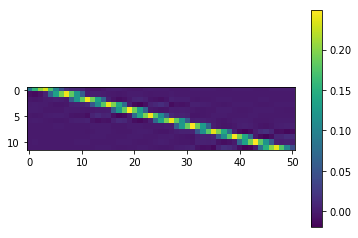

In [10]:
plt.imshow(GLOBALR)
plt.colorbar()

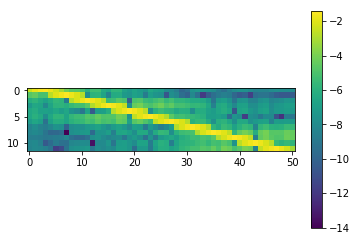

In [11]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

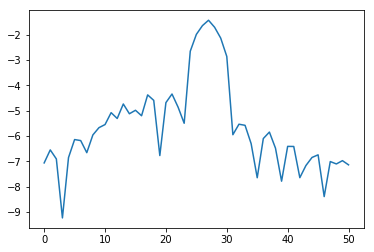

In [12]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
3.9045280278350196
L2 norm: 
0.24885318553459226
H1 norm: 
2.9080256080182503
Energy norm: 
0.3115317395710323
L2 norm: 
0.3519315500227685
H1 norm: 
0.32709130482318427
0.5656976590816036


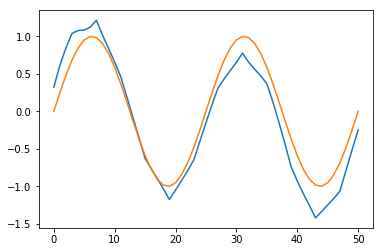

In [14]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)